# Student ID: 2320757

This code is divided into subsections as follows for sentiment analysis:
  - #### Common Codes
  - #### Exploratory Data Analysis to Understand the data
  - #### Method Unsupervised
  - #### Method Discriminative
  - #### Combined Model
  - #### State-of-The-Art Model
  - #### Comparison

Note: It is advised to run the code on GPU (ETA: 30 mins)






Installing all require libraries.

In [1]:
!pip install transformers

In [2]:
!pip install contractions

In [3]:
! pip install openai

In [4]:
!pip install vaderSentiment

Importing all require libraries.

In [5]:
import warnings
warnings.filterwarnings('ignore')

import torch
from sklearn.cluster import KMeans
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import contractions
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import GridSearchCV
from google.colab import drive
import os
import pickle
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import time
import gc
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn as nn
import time
from sklearn.model_selection import KFold
from openai import OpenAI

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**storing student id as a variable, that will be used different places**

In [6]:
student_id = 2320757 # Note this is an interger and you need to input your id

Setting seed for reproducability

In [7]:
# setting same seeds for all libraries

#numpy seed
random.seed(student_id)
np.random.seed(student_id)
torch.manual_seed(student_id)
if torch.cuda.is_available():
    torch.cuda.manual_seed(student_id)
    torch.cuda.manual_seed_all(student_id)  # if you are using multi-GPU

# Ensuring that all operations on GPU are deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Common Codes




**Code to allow the GDrive access and set data and model paths**


####Setting GDrive path and mounting

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
# Add your code to initialize GDrive and data and models paths

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = './CE807-24-SU/Assignment/'
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

List files:  ['model', 'data', 'code.ipynb']


In [10]:
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', '45') # Make sure to replace 0 with last digit of your student Regitration number
train_file = os.path.join(DATA_PATH, 'train.csv')
print('Train file: ', train_file)

val_file = os.path.join(DATA_PATH, 'valid.csv')
print('Validation file: ', val_file)

test_file = os.path.join(DATA_PATH, 'test.csv')
print('Test file: ', test_file)

Train file:  gdrive/MyDrive/./CE807-24-SU/Assignment/data/45/train.csv
Validation file:  gdrive/MyDrive/./CE807-24-SU/Assignment/data/45/valid.csv
Test file:  gdrive/MyDrive/./CE807-24-SU/Assignment/data/45/test.csv


### Common Functions

Function to read csv files and return Dataframe

In [11]:
def read_data(file):
  """
  Reads data from a CSV file and returns a Pandas DataFrame.

  Args:
    file_path (str): The path to the CSV file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from the CSV file.
  """
  file_name = os.path.basename(file)  # Extract file name from the path
  print("Reading file:", file_name)  # Print the file name being read
  df = pd.read_csv(file)
  print("Number of entries found:", len(df))  # Print the number of entries
  print('\nTop 5 rows:')
  print(df.head(5))
  return df

Function to evaluate metrics

In [12]:
# Function to evaluate metrics
def evaluate_metrics(true_labels, predictions, embeddings=None, calc_silhouette=False):
    """
    Evaluates various metrics for the given true and predicted labels.

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        embeddings (array-like, optional): The embeddings for the data. Defaults to None.
        calc_silhouette (bool, optional): Whether to calculate the silhouette score. Defaults to False.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')  # using 'weighted' for imbalanced datasets
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro')

    # Calculate class-wise accuracy
    cm = confusion_matrix(true_labels, predictions)
    class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_macro': f1_macro,
        'class_wise_accuracy': class_wise_accuracy
    }

    if calc_silhouette and embeddings is not None:
        silhouette_avg = silhouette_score(embeddings, predictions)
        metrics['silhouette_score'] = silhouette_avg

    return metrics

Function to clean the data

In [13]:
def data_cleaning(df):
  """
  Performs data cleaning on the input DataFrame.

  Args:
    df (pandas.DataFrame): The DataFrame to be cleaned.

  Returns:
    pandas.DataFrame: The cleaned DataFrame.
  """

  df['clean_text'] = df['text'].astype(str)

  # normalizing the text
  df['clean_text'] = df['clean_text'].str.lower()

  # Removing HTML tags
  df['clean_text'] = df['clean_text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" "))

  # Removing URLs
  df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

  # Remove special characters and punctuation
  df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s\.\,\!\?]', '', x))

  # Expanding contractions
  df['clean_text'] = df['clean_text'].apply(lambda x: contractions.fix(x))

  # Removing extra whitespaces
  df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()))

  return df

Function to save the model after training

In [14]:
def save_model(model_dir, model):
    """
    Saves the trained model to a specified directory.

    Args:
      model_dir (str): The directory where the model will be saved.
      model (object): The trained model to be saved.

    Returns:
      str: The path to the saved model.

    """
    model_path = os.path.join(model_dir, 'model.pkl')

    with open(model_path, 'wb') as f:
      pickle.dump(model, f)
    return model_path

Funtion to load model that is saved in directory

In [15]:
def load_saved_model(model_path):
  """
  Loads a saved model from a specified path.

  Args:
    model_path (str): The path to the saved model.

  Returns:
    object: The loaded model.
  """

  if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}")
  with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)
  return loaded_model

### Reading file data





In [16]:
# Reading training Data
train_df = read_data(train_file)

Reading file: train.csv
Number of entries found: 3681

Top 5 rows:
  sentiment                                               text
0  positive  My absolute favorite scent, and they came extr...
1  positive  I've used Stabil for many years with good resu...
2  positive  Not the fastest but its keeps chugging along. ...
3  positive    6' and 190 lbs. 45" chest.<br />XXL fits great.
4  positive                 Was as described. Easy to install.


In [17]:
# Reading Validation Data
val_df = read_data(val_file)


Reading file: valid.csv
Number of entries found: 454

Top 5 rows:
  sentiment                                               text
0  positive                       Love the product easy to use
1  positive  Is confortable , Is light weight  I really lik...
2  positive  pros-<br />brighter than halogen<br />relative...
3  positive  We visited the SCC website to verify the corre...
4  positive                        Awesome Awesome Awesome!!!!


In [18]:
# Reading Test Data
test_df = read_data(test_file)


Reading file: test.csv
Number of entries found: 409

Top 5 rows:
                                                text  out_label_model_unsup  \
0  very firm, durable and holds my phone securely...                    NaN   
1  Really reduces the glare of headlights in nigh...                    NaN   
2  Waterspots on my cars chrome trim were irritat...                    NaN   
3                      awesome sound would buy again                    NaN   
4  Excellent rear view mirror. Bought for a small...                    NaN   

   out_label_model_dis  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  


# Exploratory Data Analysis to Understand the data

In [19]:
# Loading data
df = train_df.copy()
print(df.head())

  sentiment                                               text
0  positive  My absolute favorite scent, and they came extr...
1  positive  I've used Stabil for many years with good resu...
2  positive  Not the fastest but its keeps chugging along. ...
3  positive    6' and 190 lbs. 45" chest.<br />XXL fits great.
4  positive                 Was as described. Easy to install.


The data has two columns, a text column and it's respective sentiments in the other. The text seems to be about product reviews by customers. Additionaly, there seem to be some html tags too which would need to be removed. Getting some basic statistics and information

In [20]:
# Basic statistics and information
print("Basic Information:")
print(df.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3681 entries, 0 to 3680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  3681 non-null   object
 1   text       3680 non-null   object
dtypes: object(2)
memory usage: 57.6+ KB
None


There are total 3681 rows. Also, there seems to be 1 null value in the text column. Checking for the null value and dropping it

In [21]:
# Check for null values
print("Null Values:")
print(df.isnull().sum())

print("\nRows with Null Values:")
rows_with_nulls = df[df.isnull().any(axis=1)]
print(rows_with_nulls)

print("\nNull Values before dropping:")
print(df.isnull().sum())
# Drop rows with null values
df = df.dropna()

# Verify that null values have been removed
print("\nNull Values after dropping:")
print(df.isnull().sum())



Null Values:
sentiment    0
text         1
dtype: int64

Rows with Null Values:
     sentiment text
3122  negative  NaN

Null Values before dropping:
sentiment    0
text         1
dtype: int64

Null Values after dropping:
sentiment    0
text         0
dtype: int64


Dropping the null value in original training df

In [22]:
print("\nNull Values in train_df before dropping:")
print(train_df.isnull().sum())
# Drop rows with null values
train_df = train_df.dropna()

# Verify that null values have been removed
print("\nNull Values after dropping:")
print(train_df.isnull().sum())


Null Values in train_df before dropping:
sentiment    0
text         1
dtype: int64

Null Values after dropping:
sentiment    0
text         0
dtype: int64


Checking for null values in validation set

In [23]:
print("\nNull Values in val_df:")
print(val_df.isnull().sum())


Null Values in val_df:
sentiment    0
text         0
dtype: int64


No null values found in validation set

Getting some more insights with descriptive analysis

In [24]:
print("Descriptive Statistics:")
df.describe()

Descriptive Statistics:


,sentiment,text
count,3680,3680
unique,2,3592
top,positive,Good
freq,3030,8


Looking at the above statistics it can be seen that:

*  There are equal no. of counts in both column which indicates no missing info.
*  There are 2 sentiments in the dataset that needs classifications.
*  Only 8 duplicate entries are there in text data with 'Good' being the most frequent entry.
*  The frequency of positive sentiment is very high indicating heavily imbalanced dataset.






Looking at class distribution


Sentiment Distribution:
sentiment
positive    3030
negative     650
Name: count, dtype: int64


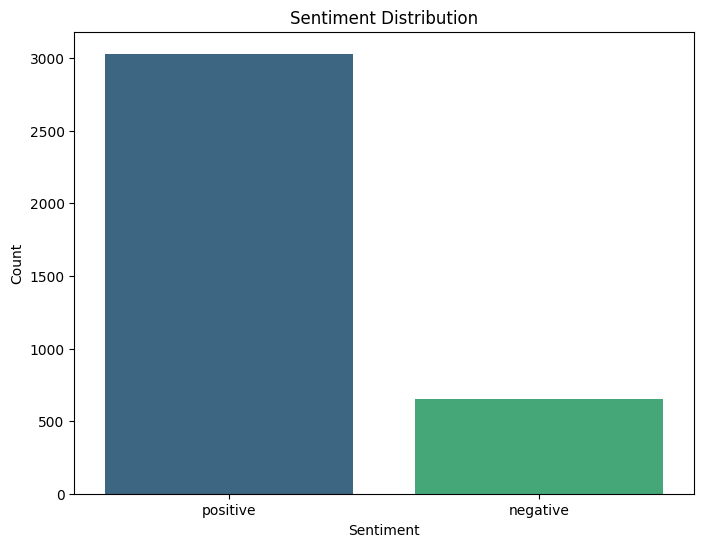

In [25]:
# Distribution of sentiment labels
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

So, there are positive and negative sentiments with the latter being the minority class

Analysing Text length distribution


Word Count Statistics:
count    3680.000000
mean       36.260326
std        50.883498
min         0.000000
25%         8.000000
50%        20.000000
75%        44.000000
max       621.000000
Name: word_count, dtype: float64


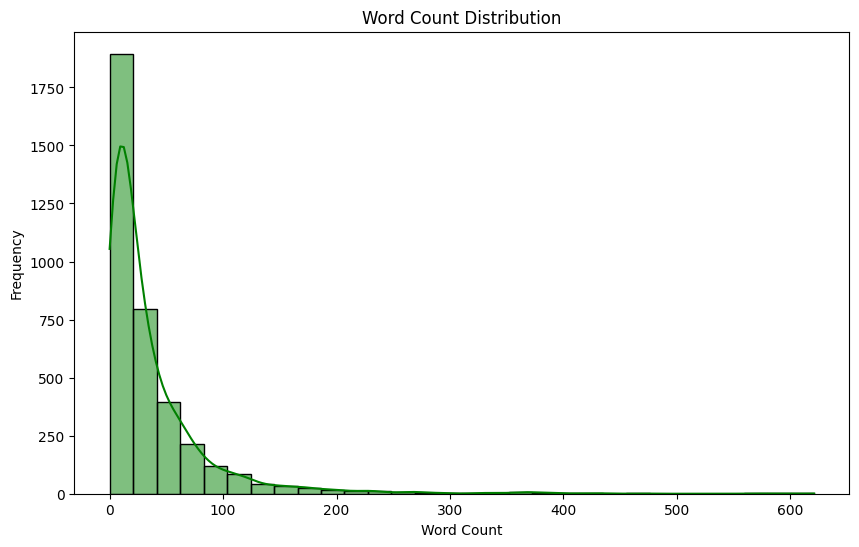

In [26]:
# Calculate the number of words in each text entry
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Display descriptive statistics for word counts
print("\nWord Count Statistics:")
print(df['word_count'].describe())

# Visualize the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True, color='green')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


Findings from word analysis in texts:
*  The average number of words in each text entry is around 36.
*  Since the median is 20, lower than the average 36, it suggests that there are a few very long text entries that are raising the average causing the right-skewed distribution.
*   The standard deviation is about 51, which means that the number of words in the text entries varies a lot.
*   A high standard deviation indicates that while some texts are short, others are very long, showing significant differences in length.


Checking sentiment-wise word count

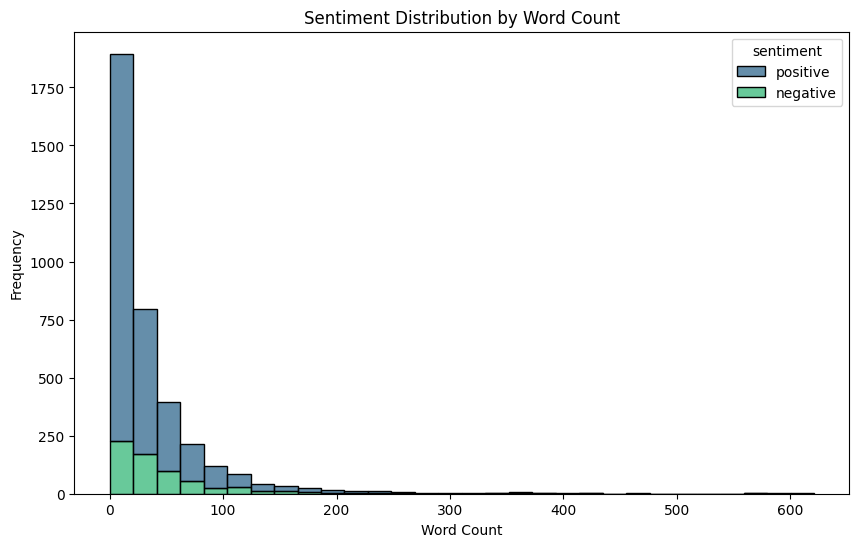

In [27]:
# Calculating the number of words in each text entry
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Visualize the sentiment distribution by word count
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', multiple='stack', palette='viridis', bins=30)
plt.title('Sentiment Distribution by Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

It is similar for both classes with most words being between the length of 0 to 40 words

Looking for some common words to understand the textual context better

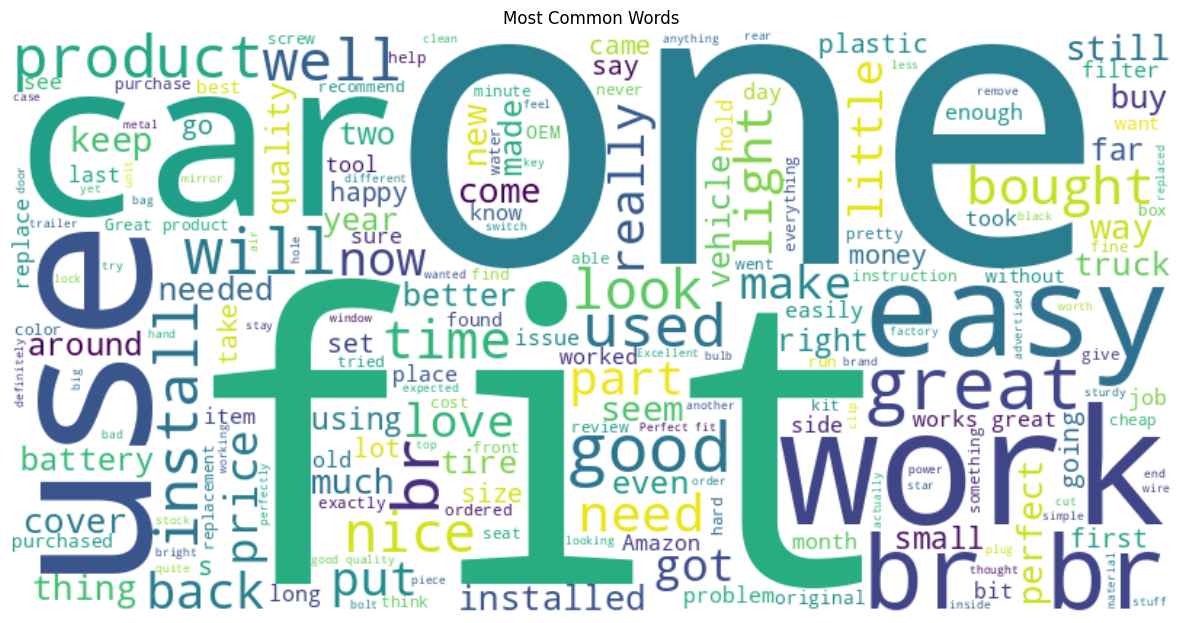

In [28]:
# Most common words
all_words = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words')
plt.show()


The text seems to be customer reviews about some car related products

# Method Unsupervised Start

##### reference: https://youtu.be/OuUG3rCm1bM?si=9bCaryWjbwtY91kb


This approach will use PCA followed by clustering for unsupervised sentiment analysis with VADER scores. This technique is adopted due to the unique advantages it offers in handling high-dimensional text data and uncovering underlying sentiment patterns without labeled data. A detailed justification of why this approach is beneficial:
1. VADER Sentiment Scores: When we use VADER to analyze text, it produces multiple scores (negative, neutral, positive, and compound) for each text entry. These scores collectively form a high-dimensional feature space which can be used for modelling as text in itself cannot be used to understand the sentiment.
2. PCA's Role: By focusing on principal components that capture the majority of the variance, it filters out noise and less informative features. This ensures that the clustering algorithm works on the most relevant features, leading to more accurate and meaningful clusters.
3. The combined approach of PCA and clustering allows us to perform sentiment analysis without requiring labeled data.
4. The clusters formed by the clustering algorithm represent groups of text entries with similar sentiment profiles. By analyzing these clusters, we can identify common sentiment trends and patterns within the dataset.

Since this is unsupervised method, so attempting to extract some features , in this case Vader sentiment scores will be calculated which would help to obtain sentiment scores (negative, neutral, positive, compound) for each text entry

Experimenting on subset of data first to get deeper insight about the working

In [29]:
sample_df = train_df.sample(n=200, random_state=student_id)
print(sample_df.head())

     sentiment                                               text
2791  positive  Had to do a little trimming and fitting but no...
430   positive  This is a very well made and beautiful  and wo...
2064  positive  I love these covers stylish for my Lincoln mkz...
3048  positive  One day, the driver-side seat fabric just came...
1103  positive  I keep it in my car all winter. Only (minor) c...


example of how VADER scores are represented

In [30]:
# Initializing vader analyzer
analyzer = SentimentIntensityAnalyzer()

# geting the scores for a single text
example_text = sample_df['text'].iloc[0]
print('example text:',example_text)
print('\nVADER scores for the text:')
print(analyzer.polarity_scores(sample_df['text'].iloc[0]))

example text: Had to do a little trimming and fitting but no biggie. It will definately keep the mud dobbers out

VADER scores for the text:
{'neg': 0.135, 'neu': 0.865, 'pos': 0.0, 'compound': -0.4215}


As it can be seen, VADER gives scores based on how much negative, positive, or neutral the text is and the overall compound score. For this example, VADER result indicates that the text has a predominantly neutral sentiment (86.5%) with a noticeable negative sentiment (13.5%), no positive sentiment (0%), and an overall negative sentiment score (compound: -0.4215).

Before calculating the vader score, cleaning and preprocessing the data as some html tags, special characters were found during exploration. Analysing which preprocessing steps would be apt steps

In [31]:
sample_val_df = val_df.copy()
print(sample_val_df.head())

  sentiment                                               text
0  positive                       Love the product easy to use
1  positive  Is confortable , Is light weight  I really lik...
2  positive  pros-<br />brighter than halogen<br />relative...
3  positive  We visited the SCC website to verify the corre...
4  positive                        Awesome Awesome Awesome!!!!


Cleaning the data step by step , calculating VADER score and applying rule based VADER model and evaluating F1-score (macro) on validation data to choose the best steps

In [32]:
# Cleaning the data step by step and evaluating F1-score (macro) on validation data
# 1. Lowercasing
sample_val_df['clean_text'] = sample_val_df['text'].str.lower()
# Calculate VADER scores and evaluate
vader_scores = sample_val_df['clean_text'].apply(analyzer.polarity_scores)
vader_df = pd.DataFrame(vader_scores.tolist())
predicted_labels = (vader_df['compound'] > 0).astype(int)
predicted_labels = predicted_labels.replace({0: 'negative', 1: 'positive'}) # Convert numerical labels to string labels
f1_macro_lower = f1_score(val_df['sentiment'], predicted_labels, average='macro')
print("F1-score (macro) after lowercasing:", f1_macro_lower)

# 2. Removing HTML tags
sample_val_df['clean_text'] = sample_val_df['clean_text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" "))
# Calculate VADER scores and evaluate
vader_scores = sample_val_df['clean_text'].apply(analyzer.polarity_scores)
vader_df = pd.DataFrame(vader_scores.tolist())
predicted_labels = (vader_df['compound'] > 0).astype(int)
predicted_labels = predicted_labels.replace({0: 'negative', 1: 'positive'}) # Convert numerical labels to string labels
f1_macro_html = f1_score(val_df['sentiment'], predicted_labels, average='macro')
print("F1-score (macro) after removing HTML tags:", f1_macro_html)

# 3. Removing URLs
sample_val_df['clean_text'] = sample_val_df['clean_text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
# Calculate VADER scores and evaluate
vader_scores = sample_val_df['clean_text'].apply(analyzer.polarity_scores)
vader_df = pd.DataFrame(vader_scores.tolist())
predicted_labels = (vader_df['compound'] > 0).astype(int)
predicted_labels = predicted_labels.replace({0: 'negative', 1: 'positive'}) # Convert numerical labels to string labels
f1_macro_url = f1_score(val_df['sentiment'], predicted_labels, average='macro')
print("F1-score (macro) after removing URLs:", f1_macro_url)

# 4. Removing special characters and punctuation
sample_val_df['clean_text'] = sample_val_df['clean_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s\.\,\!\?]', '', x))
# Calculate VADER scores and evaluate
vader_scores = sample_val_df['clean_text'].apply(analyzer.polarity_scores)
vader_df = pd.DataFrame(vader_scores.tolist())
predicted_labels = (vader_df['compound'] > 0).astype(int)
predicted_labels = predicted_labels.replace({0: 'negative', 1: 'positive'}) # Convert numerical labels to string labels
f1_macro_special = f1_score(val_df['sentiment'], predicted_labels, average='macro')
print("F1-score (macro) after removing special characters and punctuation:", f1_macro_special)

# 5. Expanding contractions
sample_val_df['clean_text'] = sample_val_df['clean_text'].apply(lambda x: contractions.fix(x))
# Calculate VADER scores and evaluate
vader_scores = sample_val_df['clean_text'].apply(analyzer.polarity_scores)
vader_df = pd.DataFrame(vader_scores.tolist())
predicted_labels = (vader_df['compound'] > 0).astype(int)
predicted_labels = predicted_labels.replace({0: 'negative', 1: 'positive'}) # Convert numerical labels to string labels

f1_macro_contractions = f1_score(val_df['sentiment'], predicted_labels, average='macro')
print("F1-score (macro) after expanding contractions:", f1_macro_contractions)

# 6. Removing extra whitespaces
sample_val_df['clean_text'] = sample_val_df['clean_text'].apply(lambda x: ' '.join(x.split()))
# Calculate VADER scores and evaluate
vader_scores = sample_val_df['clean_text'].apply(analyzer.polarity_scores)
vader_df = pd.DataFrame(vader_scores.tolist())
predicted_labels = (vader_df['compound'] > 0).astype(int)
predicted_labels = predicted_labels.replace({0: 'negative', 1: 'positive'}) # Convert numerical labels to string labels

f1_macro_whitespace = f1_score(val_df['sentiment'], predicted_labels, average='macro')
print("F1-score (macro) after removing extra whitespaces:", f1_macro_whitespace)

# 7. Stop word removal and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

sample_val_df['clean_text'] = sample_val_df['clean_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
# Calculate VADER scores and evaluate
vader_scores = sample_val_df['clean_text'].apply(analyzer.polarity_scores)
vader_df = pd.DataFrame(vader_scores.tolist())
predicted_labels = (vader_df['compound'] > 0).astype(int)
predicted_labels = predicted_labels.replace({0: 'negative', 1: 'positive'}) # Convert numerical labels to string labels

f1_macro_stop_lemma = f1_score(val_df['sentiment'], predicted_labels, average='macro')
print("F1-score (macro) after stop word removal and lemmatization:", f1_macro_stop_lemma)


F1-score (macro) after lowercasing: 0.6791324370948498
F1-score (macro) after removing HTML tags: 0.6812576312576313
F1-score (macro) after removing URLs: 0.6812576312576313
F1-score (macro) after removing special characters and punctuation: 0.688607499528924
F1-score (macro) after expanding contractions: 0.688607499528924
F1-score (macro) after removing extra whitespaces: 0.688607499528924
F1-score (macro) after stop word removal and lemmatization: 0.6546510183805265


It can be seen that after removing stop words and doing lemmatization, the accuracy significantly dropped. This is because VADER is designed to work with natural language text, including stop words. It uses them to understand the sentiment of the text as humans would. Removing stop words might lead to a loss of nuanced sentiment information that VADER is specifically built to detect. Hence, not removing the stopwords.

Also, VADER uses a lexicon of words with pre-calculated sentiment scores. These scores are based on the words in their original forms as they appear in natural language. Lemmatizing the text might lead to mismatches with VADER's lexicon, potentially reducing its accuracy hence it is skipped in this case.

Hence, following steps would be taken for the preprocessing:
1. Normalizing the text to give make all words in same case as converting to lowercase standardizes the text, ensuring that words like "Happy" and "happy" are treated the same.

2. Removing HTML tags, URLs as these do not contribute to sentiment and can add noise to the analysis.

3. Cleaning the text from non-alphanumeric characters that might confuse the sentiment analysis. However, keeping punctuations like ! as these are taken into account in VADER do determine the sentiment score.

4. Expanding contractions into their full forms, which helps in better sentiment analysis as VADER is lexicon based and can understand the full meaning of the words. The accuracy didn't improve on validation set after this step, but still some since it is review data this step may be helpful on the remaining data.

5. Removing Extra Whitespace as it ensures that the text does not have irregular spacing, making it more uniform for analysis.


In [33]:
# Calling the data cleaning and preprocessing function created which will do the above mentioned steps.
sample_df = data_cleaning(sample_df)
print(sample_df.head())

     sentiment                                               text  \
2791  positive  Had to do a little trimming and fitting but no...   
430   positive  This is a very well made and beautiful  and wo...   
2064  positive  I love these covers stylish for my Lincoln mkz...   
3048  positive  One day, the driver-side seat fabric just came...   
1103  positive  I keep it in my car all winter. Only (minor) c...   

                                             clean_text  
2791  had to do a little trimming and fitting but no...  
430   this is a very well made and beautiful and wor...  
2064  i love these covers stylish for my lincoln mkz...  
3048  one day, the driverside seat fabric just came ...  
1103  i keep it in my car all winter. only minor com...  


Now computing the VADER scores for the cleaned data

Calculating the VADER scores for the subset data for further steps



In [34]:

# fetching scores for the texts in df
texts = sample_df['clean_text'].values
scores = [analyzer.polarity_scores(text) for text in texts]
print(f'VADER scores for each text:\n')
score_df = pd.DataFrame(scores)
print(score_df.head())

VADER scores for each text:

     neg    neu    pos  compound
0  0.135  0.865  0.000   -0.4215
1  0.000  0.509  0.491    0.8265
2  0.000  0.781  0.219    0.6369
3  0.000  0.824  0.176    0.7184
4  0.123  0.790  0.087   -0.0790


We know that based on compound column we can build a rule based model which was giving the F1 score around 0.68 (seen during finding the right preprocessing steps). Hence doing further steps to improve the performance

Now there are 4 features, however we need two of the sentiments negative and positive and all the 4 features contribute in determining that. Hence we need to reduce the dimentionality. Therefore, applying PCA to reduce the dimensionality of these sentiment scores, keeping the most significant components that capture the majority of the variance in the sentiment data.


In [35]:
# Applying PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reducing to 2 components we will later chose better one if possible in grid search cv
reduced_features = pca.fit_transform(score_df)

# Creating a DataFrame with reduced features
reduced_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
print(reduced_df.head())


        PC1       PC2
0  0.921898  0.092885
1 -0.471802  0.121743
2 -0.142199 -0.152198
3 -0.191017 -0.240544
4  0.563184  0.057764


Finally, applying KMeans clustering algorithm to the PCA-reduced data to group similar reviews together as this would helps in identifying clusters of reviews with similar sentiment profiles.

                                             clean_text  cluster
2791  had to do a little trimming and fitting but no...        1
430   this is a very well made and beautiful and wor...        0
2064  i love these covers stylish for my lincoln mkz...        0
3048  one day, the driverside seat fabric just came ...        0
1103  i keep it in my car all winter. only minor com...        1
...                                                 ...      ...
1503        not much to say here . . . its a tire tool.        1
2769  nice quality, they look a bit bulky but they a...        0
1376  great product, fast ship, good sell, will buy ...        0
2907  huge fluid capacity, easy to install, really i...        0
943   we put this under our water softener for safet...        1

[200 rows x 2 columns]
          PC1       PC2  cluster
0    0.921898  0.092885        1
1   -0.471802  0.121743        0
2   -0.142199 -0.152198        0
3   -0.191017 -0.240544        0
4    0.563184  0.057764        

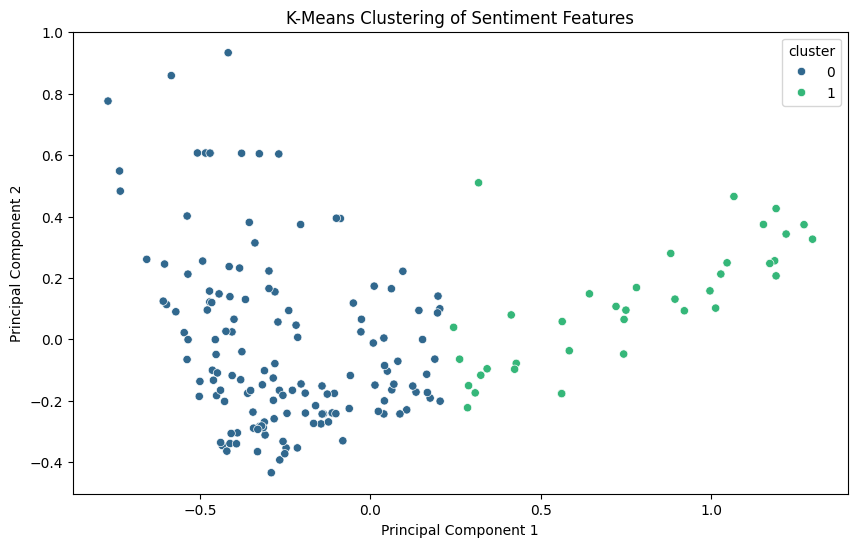

In [36]:
# Performing K-Means clustering with k=2 (for positive and negative sentiments)
kmeans = KMeans(n_clusters=2, random_state=student_id)
reduced_df['cluster']  = kmeans.fit_predict(reduced_df)
sample_df['cluster']  = reduced_df['cluster'].values

# Printing cluster assignments
print(sample_df[['clean_text', 'cluster']])
# Printing from reduced_df
print(reduced_df[['PC1', 'PC2', 'cluster']])

# Plotting clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=reduced_df, palette='viridis')
plt.title('K-Means Clustering of Sentiment Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Cluster 1 seems to represent positive sentiment and cluster 0 the negative one and the predictions seem appropriate.

Now that the approach is clear, starting the training on complete dataset.

## Training Unsupervised Method Code

Function to get the VADER score on text, also some lexicons are updated for fine-tuning based on customer review data.

In [37]:
# Function to get VADER scores

def get_vader_scores(df):
    """
    Calculates VADER sentiment scores for a list of text entries.

    Args:
      texts: A list of strings, where each string represents a text entry.

    Returns:
      A pandas DataFrame containing the VADER sentiment scores (negative, neutral, positive, compound) for each text entry.
    """

    texts = df['clean_text'].values
    analyzer = SentimentIntensityAnalyzer()
    # Updating lexicons for fine-tuning
    new_words = {
        'awesome': 5.0, 'fantastic': 4.0, 'good': 3.0, 'seamless': 3.0, 'excelente': 4.0, 'excelent': 4.0,
        'horrible': -3.5, 'worst': -4.0, 'perfect': 4.0, 'decent': 2.0, 'love': 3.5, 'glad': 4.0, 'lowest': -3.5,
        'works': 3.0, 'timely': 3.0, 'expected': 2.0, 'however': -4.0, 'nice': 3.0, 'better': 1.0, 'years': 1.0,
        'flimsy': 2.0, 'exactly': 3.5, 'durable': 3.5, 'issue': 2.0, 'easy': 3.0
    }
    analyzer.lexicon.update(new_words)
    scores = [analyzer.polarity_scores(text) for text in texts]
    score_df = pd.DataFrame(scores)
    return score_df[['neg', 'neu', 'pos', 'compound']]

Custom KMeans class with prediction labels adjustment for further use in pipeline

In [38]:
# prompt: in the below code can you document the input functionality and output according to coding standards

import numpy as np
# Custom KMeans class with prediction labels adjustment for further use in pipeline
class CustomKMeans(BaseEstimator, ClusterMixin):
  """
  A custom KMeans clustering class that adjusts prediction labels
  to align with sentiment polarity (positive as 1, negative as 0).

  Parameters
  ----------
  n_clusters : int, default=2
      The number of clusters to form as well as the number of
      centroids to generate.

  random_state : int, RandomState instance or None, default=None
      Determines random number generation for centroid initialization.

  Attributes
  ----------
  kmeans_ : sklearn.cluster.KMeans object
      The fitted KMeans model.

  labels_ : ndarray of shape (n_samples,)
      Labels of each point. Adjusted to represent sentiment polarity.

  """
  def __init__(self, n_clusters=2, random_state=None):
    self.n_clusters = n_clusters
    self.random_state = random_state

  def fit(self, X, y=None):
    """
    Compute k-means clustering.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training instances to cluster.

    y : Ignored
        Not used, present here for API consistency by convention.

    Returns
    -------
    self : object
        Fitted estimator.
    """
    self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X)
    self.labels_ = self.adjust_labels(X)
    return self

  def predict(self, X):
    """
    Predict the closest cluster each sample in X belongs to.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        New data to predict.

    Returns
    -------
    labels : ndarray of shape (n_samples,)
        Index of the cluster each sample belongs to. Adjusted for sentiment polarity.
    """
    return self.adjust_labels(X)

  def adjust_labels(self, X):
    """
    Adjusts cluster labels to represent sentiment polarity.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Data used to determine label adjustment.

    Returns
    -------
    adjusted_labels : ndarray of shape (n_samples,)
        Labels adjusted to represent sentiment polarity.
    """
    # Predict clusters
    predicted_labels = self.kmeans_.predict(X)

    # Calculate mean compound sentiment score for each cluster
    mean_compound_scores = [np.mean(X['compound'][predicted_labels == i]) for i in range(self.n_clusters)]

    # Determine which cluster corresponds to positive sentiment
    positive_cluster = np.argmax(mean_compound_scores)

    # Adjust labels: positive cluster as 1, negative cluster as 0
    adjusted_labels = np.where(predicted_labels == positive_cluster, 1, 0)
    return adjusted_labels


Custom KMeans with prediction labels adjustment

In [39]:
# Custom KMeans with prediction labels adjustment
class CustomKMeans(BaseEstimator, ClusterMixin):
    """
  A custom KMeans clustering class that adjusts prediction labels
  to align with sentiment polarity (positive as 1, negative as 0).

  Parameters
  ----------
  n_clusters : int, default=2
      The number of clusters to form as well as the number of
      centroids to generate.

  random_state : int, RandomState instance or None, default=None
      Determines random number generation for centroid initialization.

  Attributes
  ----------
  kmeans_ : sklearn.cluster.KMeans object
      The fitted KMeans model.

  labels_ : ndarray of shape (n_samples,)
      Labels of each point. Adjusted to represent sentiment polarity.

  """
    def __init__(self, n_clusters=2, max_iter=300, random_state=2320757):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state)

    def fit(self, X, y=None):
        """
        Compute k-means clustering.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.

        y : Ignored
            Not used, present here for API consistency by convention.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        self.kmeans.fit(X)
        self.labels_ = self.kmeans.labels_
        self._adjust_labels()
        return self

    def predict(self, X):
        """
        Predict the closest cluster each sample in X belongs to.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to predict.

        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to. Adjusted for sentiment polarity.
        """
        labels = self.kmeans.predict(X)
        label_counts = np.bincount(labels)
        if len(label_counts) == 2 and label_counts[0] > label_counts[1]:
            labels = np.where(labels == 0, 1, 0)
        return labels

    def _adjust_labels(self):
        """
        Adjusts cluster labels to represent sentiment polarity.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data used to determine label adjustment.

        Returns
        -------
        adjusted_labels : ndarray of shape (n_samples,)
            Labels adjusted to represent sentiment polarity.
        """
        label_counts = np.bincount(self.labels_)
        if len(label_counts) == 2 and label_counts[0] > label_counts[1]:
            self.labels_ = np.where(self.labels_ == 0, 1, 0)

 Custom scoring function for silhouette score to be used to find best parameters in grid search cv

In [40]:
# Custom scoring function for silhouette score
def silhouette_scorer(estimator, X):
    """
    Calculates the silhouette score for the given estimator and data.

    Args:
      estimator: A fitted scikit-learn clustering estimator.
      X: The data to evaluate the clustering on.
      y: Ignored. (Present for compatibility with scoring functions.)

    Returns:
      The silhouette score of the clustering.
    """
    embeddings = estimator.named_steps['dimensionality_reduction'].transform(estimator.named_steps['vader_scoring'].transform(estimator.named_steps['data_cleaning'].transform(X)))
    labels = estimator.named_steps['clustering'].predict(embeddings)
    return silhouette_score(embeddings, labels)


Funtion to train the data, finding the best parameters and validation

In [41]:
def train_unsup(train_file, val_file, model_dir):
    """
    Trains an unsupervised sentiment analysis model using VADER, PCA, and KMeans and then validation.

    Args:
      train_df: Pandas DataFrame containing the training data with a 'text' column.
      val_df: Pandas DataFrame containing the validation data with a 'text' column and 'sentiment' column.

    Returns:
      A trained scikit-learn Pipeline object.
    """
    print('Loading the data...')
    train_df = read_data(train_file)
    val_df = read_data(val_file)
    print('Training started...\n')
    print('Implementing GridSearchCV to get best parameters')
    # Creating pipeline
    pipeline = Pipeline([
        ('data_cleaning', FunctionTransformer(data_cleaning, validate=False)),
        ('vader_scoring', FunctionTransformer(get_vader_scores, validate=False)),
        ('dimensionality_reduction', PCA(n_components=4)),
        ('clustering', CustomKMeans())
    ])

    # Adding labels to validation data
    val_df['label'] = val_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

    # Define parameter grid for GridSearchCV
    param_grid = {
        'dimensionality_reduction__n_components': [2, 3, 4],
        'clustering__max_iter': [200, 300, 400, 500]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, scoring=silhouette_scorer, cv=3)

    # Fit the GridSearchCV on training data
    grid_search.fit(train_df)

    # Get the best estimator
    best_pipeline = grid_search.best_estimator_
    print('Fetched best parameters as:')
    print(f'grid_search.best_params_{grid_search.best_params_}')
    print('Training complete.\n')

    # Calculate silhouette score for training data
    train_scores = get_vader_scores(data_cleaning(train_df))
    reduced_train_scores = best_pipeline.named_steps['dimensionality_reduction'].transform(train_scores)
    train_predictions = best_pipeline.named_steps['clustering'].predict(reduced_train_scores)
    train_silhouette_score = silhouette_score(reduced_train_scores, train_predictions)
    print(f"Training Silhouette Score: {train_silhouette_score}")

    print('Validating...')

    # Predict clusters for validation data
    val_scores = get_vader_scores(data_cleaning(val_df))
    reduced_val_scores = best_pipeline.named_steps['dimensionality_reduction'].transform(val_scores)
    validation_predictions = best_pipeline.named_steps['clustering'].predict(reduced_val_scores)

    # Evaluate clustering performance using validation labels
    metrics = evaluate_metrics(val_df['label'], validation_predictions, reduced_val_scores, calc_silhouette=True)

    print(f"\nOverall Accuracy: {metrics['accuracy']}")
    print(f"Class-wise Accuracy: {metrics['class_wise_accuracy']}")
    if 'silhouette_score' in metrics:
        print(f"Silhouette Score: {metrics['silhouette_score']}")

    print(f"Validation Accuracy: {metrics['accuracy']}")
    print(f"Validation Precision (weighted): {metrics['precision']}")
    print(f"Validation Recall (weighted): {metrics['recall']}")
    print(f"Validation F1 Score: {metrics['f1']}")
    print(f"Validation F1 Score (macro): {metrics['f1_macro']}")

    # Plot the confusion matrix
    cm = confusion_matrix(val_df['label'], validation_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    val_df['predicted_label'] = validation_predictions
    val_df['predicted_sentiment'] = ['positive' if pred == 1 else 'negative' for pred in validation_predictions]
    print('Validation Done')
    print('Saving the best model...')
    saved_model_path = save_model(model_dir, best_pipeline)
    print('Model saved to ',saved_model_path)
    return val_df, best_pipeline, saved_model_path


Calling the train_unsup function which would perform the following steps:
1. Data cleaning and preprocessing
2. Extracting VADER score using fine-tuned VADER analyzer
3. PCA for dimentionality reduction on VADER features
4. Clustering
5. Grid search CV to get best parameters for KMeans iterations and PCA's components
6. Using the the best pipeline for validation data predictions
7. Evaluating performance
8. Returning predictions and best pipeline

Loading the data...
Reading file: train.csv
Number of entries found: 3681

Top 5 rows:
  sentiment                                               text
0  positive  My absolute favorite scent, and they came extr...
1  positive  I've used Stabil for many years with good resu...
2  positive  Not the fastest but its keeps chugging along. ...
3  positive    6' and 190 lbs. 45" chest.<br />XXL fits great.
4  positive                 Was as described. Easy to install.
Reading file: valid.csv
Number of entries found: 454

Top 5 rows:
  sentiment                                               text
0  positive                       Love the product easy to use
1  positive  Is confortable , Is light weight  I really lik...
2  positive  pros-<br />brighter than halogen<br />relative...
3  positive  We visited the SCC website to verify the corre...
4  positive                        Awesome Awesome Awesome!!!!
Training started...

Implementing GridSearchCV to get best parameters
Fetched best paramete

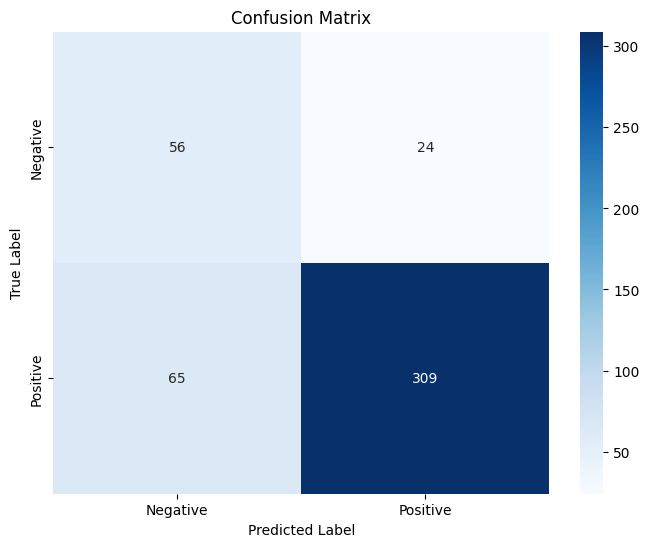

Validation Done
Saving the best model...
Model saved to  gdrive/MyDrive/./CE807-24-SU/Assignment/model/2320757/Model_Unsup/model.pkl


In [42]:
model_dir = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Unsup')
os.makedirs(model_dir, exist_ok=True)
val_df_with_predictions, model_pipeline, saved_model_path = train_unsup(train_file, val_file, model_dir)

Let's look at the performance metrics:

- **Overall Accuracy:** 0.8039647577092511. This means that about 80.4% of the predictions made by model are correct. Hower, since the data is imbalanced, it doesn't really capture the performance class wise.

- **Class-wise Accuracy:** [0.7, 0.82620321]. The positive class has a higher accuracy, indicating the model performs better at predicting positive sentiments than negative ones.

- **Silhouette Score:** 0.5222905223719643. A score of 0.52 suggests moderate clustering quality, meaning the embeddings from the model create somewhat distinguishable clusters for the different sentiment classes.

- **Validation Precision (weighted):** 0.8459688071221911. A precision of 0.846 means that when the model predicts a class, it is correct about 84.6% of the time, weighted by the prevalence of each class in the validation set.
- **Validation Recall (weighted):** 0.8039647577092511. A recall of 0.804 means that the model correctly identifies 80.4% of the actual instances of each class, weighted by the class prevalence.
- **Validation F1 Score:** 0.8741159830268741. A high F1 score of 0.874 indicates that the model balances precision and recall well, with strong performance in both areas.
- **Validation F1 Score (macro):** 0.7156649566875664. A macro F1 score of 0.716 suggests that while the model performs well overall, there is a notable discrepancy in performance between classes, the negative class to be specific.

## Testing Method Unsupervised Code

Function to test the data and saving the results to test csv

In [43]:
# Function to predict test data and overwrite labels in the test CSV
def test_unsup(test_file, model_file, output_dir):
    """
    Tests an unsupervised sentiment analysis model and saves the results to a CSV file.

    Args:
        test_file (str): Path to the CSV file containing the test data.
        saved_model_path (str): Path to the saved model file.
        result_dir (str): Directory where the result CSV file will be saved.

    Returns:
        pandas.DataFrame: DataFrame containing the test data with predicted sentiments and confidence scores.
    """
    print('Loading the best model...')
    test_df = read_data(test_file)
    pipeline = load_saved_model(model_file)
    test_df_clean = data_cleaning(test_df)
    test_scores = get_vader_scores(test_df_clean)
    reduced_test_scores = pipeline.named_steps['dimensionality_reduction'].transform(test_scores)
    test_predictions = pipeline.named_steps['clustering'].predict(reduced_test_scores)
    test_sentiment = ['positive' if pred == 1 else 'negative' for pred in test_predictions]
    test_df['out_label_model_unsup'] = test_sentiment
    silhouette_avg = silhouette_score(reduced_test_scores, test_predictions)
    print(f"\nSilhouette Score: {silhouette_avg}\n")
    if 'clean_text' in test_df.columns:
      test_df = test_df.drop('clean_text', axis=1)
    test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)
    print(f"Test data predictions saved to {output_dir}")
    return test_df

Loading the best model and testing

In [44]:
# Loading the best pipeline and testing
print('Testing started...')
if saved_model_path is not None:
  model_file = saved_model_path
else:
  model_file = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Unsup', 'model.pkl')

output_dir = os.path.join(GOOGLE_DRIVE_PATH, 'data', str(45))
test_df = test_unsup(test_file, model_file, output_dir)
print('Testing complete.')

Testing started...
Loading the best model...
Reading file: test.csv
Number of entries found: 409

Top 5 rows:
                                                text  out_label_model_unsup  \
0  very firm, durable and holds my phone securely...                    NaN   
1  Really reduces the glare of headlights in nigh...                    NaN   
2  Waterspots on my cars chrome trim were irritat...                    NaN   
3                      awesome sound would buy again                    NaN   
4  Excellent rear view mirror. Bought for a small...                    NaN   

   out_label_model_dis  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  

Silhouette Score: 0.5457532825650689

Test data predictions saved to gdrive/MyDrive/./CE807-24-SU/Assignment/data/45
Testing complete.


Visualizing the test data

In [45]:
display(test_df.head(10))

,text,out_label_model_unsup,out_label_model_dis
0,"very firm, durable and holds my phone securely...",positive,NaN
1,Really reduces the glare of headlights in nigh...,positive,NaN
2,Waterspots on my cars chrome trim were irritat...,positive,NaN
3,awesome sound would buy again,positive,NaN
4,Excellent rear view mirror. Bought for a small...,positive,NaN
5,Thank you for the exceptional customer servic...,positive,NaN
6,"Have changed several dirt bike tires, and thes...",negative,NaN
7,"Contrary to the intended use, this is on an ex...",positive,NaN
8,This is a great little unit to keep in the tru...,positive,NaN
9,AS Expected,positive,NaN


## Analysis (Unsupervised Method)

Visualizing the predictions

In [46]:
display(val_df_with_predictions.head(10))


,sentiment,text,label,clean_text,predicted_label,predicted_sentiment
0,positive,Love the product easy to use,1,love the product easy to use,1,positive
1,positive,"Is confortable , Is light weight I really lik...",1,"is confortable , is light weight i really like...",1,positive
2,positive,pros-<br />brighter than halogen<br />relative...,1,pros brighter than halogen relatively easy to ...,1,positive
3,positive,We visited the SCC website to verify the corre...,1,we visited the scc website to verify the corre...,1,positive
4,positive,Awesome Awesome Awesome!!!!,1,awesome awesome awesome!!!!,1,positive
5,positive,Works however the included caps only fit one o...,1,works however the included caps only fit one o...,0,negative
6,positive,Looks great! Thank you!,1,looks great! thank you!,1,positive
7,positive,Good value !,1,good value !,1,positive
8,negative,I had no idea how to install these - came in p...,0,i had no idea how to install these came in par...,0,negative
9,positive,These have worked great for the last 4 month. ...,1,these have worked great for the last 4 month. ...,1,positive


Now, calculating the confidence score for each prediction. Since KMeans doesn't provide probabilities directly, hence calculating the distance of each sample from its cluster center to estimate confidence. The closer a sample is to its cluster center, the higher the confidence.

In [47]:
# Calculating distances to cluster centers for confidence estimation
val_embeddings = model_pipeline.named_steps['dimensionality_reduction'].transform(
    model_pipeline.named_steps['vader_scoring'].transform(
        model_pipeline.named_steps['data_cleaning'].transform(val_df_with_predictions)
    )
)
cluster_centers = model_pipeline.named_steps['clustering'].kmeans.cluster_centers_
distances = np.linalg.norm(val_embeddings[:, None, :] - cluster_centers[None, :, :], axis=2)
val_df_with_predictions['confidence'] = 1 - np.min(distances, axis=1) / np.max(distances)
display(val_df_with_predictions.head(10))


,sentiment,text,label,clean_text,predicted_label,predicted_sentiment,confidence
0,positive,Love the product easy to use,1,love the product easy to use,1,positive,0.773061
1,positive,"Is confortable , Is light weight I really lik...",1,"is confortable , is light weight i really like...",1,positive,0.762571
2,positive,pros-<br />brighter than halogen<br />relative...,1,pros brighter than halogen relatively easy to ...,1,positive,0.822305
3,positive,We visited the SCC website to verify the corre...,1,we visited the scc website to verify the corre...,1,positive,0.756795
4,positive,Awesome Awesome Awesome!!!!,1,awesome awesome awesome!!!!,1,positive,0.512392
5,positive,Works however the included caps only fit one o...,1,works however the included caps only fit one o...,0,negative,0.678593
6,positive,Looks great! Thank you!,1,looks great! thank you!,1,positive,0.698640
7,positive,Good value !,1,good value !,1,positive,0.630032
8,negative,I had no idea how to install these - came in p...,0,i had no idea how to install these came in par...,0,negative,0.643839
9,positive,These have worked great for the last 4 month. ...,1,these have worked great for the last 4 month. ...,1,positive,0.898250


In [48]:
# Copying the predictions df for indepth analysis in later stages
val_unsup_predictions = val_df_with_predictions.copy()

Looking at some examples from each class for more insight

In [49]:
pd.set_option('display.max_colwidth', None)
print('Positive Examples:')
display(val_unsup_predictions[val_unsup_predictions['predicted_sentiment'] == 'positive'].sample(5))

print('\nNegative Examples:')
display(val_unsup_predictions[val_unsup_predictions['predicted_sentiment'] == 'negative'].sample(5))
pd.reset_option('display.max_colwidth')


Positive Examples:


,sentiment,text,label,clean_text,predicted_label,predicted_sentiment,confidence
317,positive,Good price and quality oil for the car.,1,good price and quality oil for the car.,1,positive,0.913788
287,positive,Direct replacement. Looks just like original,1,direct replacement. looks just like original,1,positive,0.852138
58,positive,Fit was perfect and quality looks great.,1,fit was perfect and quality looks great.,1,positive,0.716333
270,positive,"Installed this on a 2018 HPX615e - total installation time was about 4 hours. As others have pointed out, the instructions aren’t great. My main complaint was that I had to trim the firewall a bit - the steering shaft hit it otherwise. In doing some research, it sounds like this is fairly common. The annoying part is that there is no mention of this in the instructions, and you wouldn’t ever know it was an issue until you had finished the installation and saw that it was interfering. At which point you have to disassemble it all to get space to trim the firewall. If they just told you up front to check the clearance it wouldn’t have been a big deal.<br /><br />Tips on the installation:<br />- Remove the hood - it makes it a lot easier to get down at the steering rack and it’s only 2 bolts.<br />- Consider what other stuff you have that might complicate the installation of the electronics - my HPX has the controller for the plow plus some aftermarket lights, which made finding space under the hood for the wiring a bit trickier.<br />- Take pictures of the back of the dash as you remove it, so you can remember where you disconnected the wires from. :)<br /><br />The end result if you suffer through the instructions though is FANTASTIC. I have a large 6’ BOSS snowplow on the front of the HPX and I can still turn the wheel with a single hand with it installed - the assist from the power steering is absolutely perfect.<br /><br />So, yeah - I guess the recap is that the installation is a pain, but the end result is worth it.",1,"installed this on a 2018 hpx615e total installation time was about 4 hours. as others have pointed out, the instructions are not great. my main complaint was that i had to trim the firewall a bit the steering shaft hit it otherwise. in doing some research, it sounds like this is fairly common. the annoying part is that there is no mention of this in the instructions, and you would not ever know it was an issue until you had finished the installation and saw that it was interfering. at which point you have to disassemble it all to get space to trim the firewall. if they just told you up front to check the clearance it would not have been a big deal. tips on the installation remove the hood it makes it a lot easier to get down at the steering rack and its only 2 bolts. consider what other stuff you have that might complicate the installation of the electronics my hpx has the controller for the plow plus some aftermarket lights, which made finding space under the hood for the wiring a bit trickier. take pictures of the back of the dash as you remove it, so you can remember where you disconnected the wires from. the end result if you suffer through the instructions though is fantastic. i have a large 6 boss snowplow on the front of the hpx and i can still turn the wheel with a single hand with it installed the assist from the power steering is absolutely perfect. so, yeah i guess the recap is that the installation is a pain, but the end result is worth it.",1,positive,0.735214
405,positive,"Love the size, holds 6 sets of keys",1,"love the size, holds 6 sets of keys",1,positive,0.950671



Negative Examples:


,sentiment,text,label,clean_text,predicted_label,predicted_sentiment,confidence
136,negative,The black trim around the outer edge is breaking down and leaving black marks on the upholstery!,0,the black trim around the outer edge is breaking down and leaving black marks on the upholstery!,0,negative,0.890453
232,positive,"Simple shock, straight forward to install, working well in our minivan",1,"simple shock, straight forward to install, working well in our minivan",0,negative,0.761855
185,positive,I just got for me to start riding so haven't actually used besides looking in the mirror.,1,i just got for me to start riding so have not actually used besides looking in the mirror.,0,negative,0.890453
171,negative,expanders literally bent and snapped trying to expand some 18 gauge (this is thinner than average) exhaust pipe. i wouldnt recommend this even for use on plastic.,0,expanders literally bent and snapped trying to expand some 18 gauge this is thinner than average exhaust pipe. i would not recommend this even for use on plastic.,0,negative,0.916228
94,negative,"[[VIDEOID:34948877e1ca8ed367ab878c5d940d94]] I just took it out of the Box to test it and the pictures show the way I found it.<br /><br /> Check out my video using the impact gun for the 1st time. It is a complete piece of junk.. I am an industrial maintenance mechanic for 37 years and I am here to tell you, absolutely under no circumstances purchased this product as it will leave you stranded, possibly in a dangerous situation on the side of a road.<br /><br /> I will be purchasing a small bottle Jack and a wrench and socket with a cheater bar. The cheater bar is to get extra leverage for stubborn nuts and bolts .",0,"videoid34948877e1ca8ed367ab878c5d940d94 i just took it out of the box to test it and the pictures show the way i found it. check out my video using the impact gun for the 1st time. it is a complete piece of junk.. i am an industrial maintenance mechanic for 37 years and i am here to tell you, absolutely under no circumstances purchased this product as it will leave you stranded, possibly in a dangerous situation on the side of a road. i will be purchasing a small bottle jack and a wrench and socket with a cheater bar. the cheater bar is to get extra leverage for stubborn nuts and bolts .",0,negative,0.530978


Acording to the data above, the model is seen to exhibit some strength and weaknesses:

**Strength:**
- The model is highly confident in sentences which has more words.
- decent confidence in both classes.
- The model shows high confidence in reviews with clear, unambiguous sentiments. For example, "just as described. delivered very quickly! No complaints" is correctly identified as positive with high confidence (0.843126)
- The model accurately identifies strongly negative reviews with high confidence. For instance, "Worked first 2 times. Now won't work at all. Junk!" is correctly predicted as negative with a confidence score of 0.890453.

**Weakness**:
-  The model misclassifies some positive reviews as negative with high confidence. For example, "High quality, but bought as spares" is predicted as negative with a confidence score of 0.890453. This indicates overconfidence in certain incorrect predictions.
- It is not confident enough in predicting the negative class.
- Its confidence is not much especially for scentences with fewer words like in good value! or Awesome Awesome Awesome.
- For row index 5, the model incorrectly predicted negative sentiment with moderate confidence, indicating it was influenced by negative details despite the overall positive sentiment.

Summary:
- The model performs well overall, particularly in predicting positive sentiments, as shown by the class-wise accuracy.
- The silhouette score indicates decent clustering, meaning the model's embeddings are reasonably well-separated.
- The high weighted precision and F1 score indicate that the model makes accurate predictions and balances precision and recall well.
- The macro F1 score reveals some imbalance in class performance, suggesting room for improvement in predicting the less accurately predicted class which is negative one.
- The model accurately identifies and shows high confidence in reviews with clear, unambiguous sentiments.
- The model successfully identifies strongly negative reviews with high confidence
- The model sometimes misclassifies positive reviews as negative with high confidence
- Simplistic or less expressive reviews like "Just as advertised" are sometimes incorrectly predicted with high confidence.

## Method Unsupervised End


# Method Discriminative Start

For the discriminative model, a pretrained DistillBert model by hugging face would be used which would further be fine-tuned for the provided dataset using Pytorch neural networks.
Modelling steps and their justification as to why it was adopted:

1. Data Cleaning:
Same data cleaning steps would be used for this model as well as just like VADER gives scores to every word, BERT weigh the importance of different words in a sentence relative to each other. Hence, removing only noise(like tags) and not using lemmatization or stopping words.

2. Tokenization and Encoding:
Using a pre-trained tokenizer from a model like DistilBERT which would that tokenization aligns with the model's training, maximizing performance. The tokenizer converts text into tokens that the model can process. This step is crucial as it breaks down text into manageable pieces (tokens), which the model can analyze individually.

4. Model Architecture:
Using a transformer-based model DistilBERT as it is pre-trained on large text corpora, capturing extensive language features, which are then fine-tuned for our specific task with additional layers which adapt the model to the specific requirements, improving its accuracy in distinguishing between positive and negative sentiments.

5. Training and Validation:
Key components like loss function, optimizer, learning rate scheduler, and early stopping are critical. For efficient Learning AdamW optimizer is used.
Also, adding Early stopping to ensure the model does not learn noise from the training data, maintaining generalization capabilities.

6. Hyperparameter Tuning:
Hyperparameter tuning through KFold cross-validation is done for finding optimal batch size and learning rate for getting the best model.

7. Evaluation Metrics:
Given the highly imbalanced dataset, multiple metrics are used
F1 Score (Macro): Balances precision and recall, treating both classes equally important.
Precision and Recall (Weighted): Provide insights into the model's ability to handle imbalanced data.
Class-Wise Accuracy: Offers detailed performance information for each class.
Confusion Matrix: Visualizes how well the model distinguishes between positive and negative sentiments.
These metrics give a comprehensive evaluation, ensuring the model is reliable across different aspects.

8. Testing the model on the test set

Looking at a sample text to understand how the tokenization, encoding and prediction for distillBert is done

In [50]:
# reference: https://huggingface.co/juliensimon/reviews-sentiment-analysis
# Initializing the model and tokenizer for it
model_name = f'juliensimon/reviews-sentiment-analysis'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [51]:
# Tokenize the sample text
sample_text = val_df.iloc[10].values[1]
sample_label = val_df.iloc[10].values[0]
print('sample_text:', sample_text)
print('Tokenizing and encoding text')
sample_encoding = tokenizer(sample_text, truncation=True, padding=True, return_tensors='pt')

print('Text encoding:',sample_encoding)

# Performing inference
model.eval()
with torch.no_grad():
    outputs = model(**sample_encoding)
    logits = outputs.logits

# Getting the predicted class
predicted_class = torch.argmax(logits, dim=1).item()

# Printing the predicted sentiment
if predicted_class == 1:
    print("Predicted Sentiment: Positive")
else:
    print("Predicted Sentiment: Negative")
print('Ground Truth:', sample_label)



sample_text: Like the size. Last a long time. Good price.
Tokenizing and encoding text
Text encoding: {'input_ids': tensor([[ 101, 2066, 1996, 2946, 1012, 2197, 1037, 2146, 2051, 1012, 2204, 3976,
         1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Predicted Sentiment: Positive
Ground Truth: positive


The text was correctly predicted. We encoded the text because transformer models like BERT don't work directly with raw text. They require numerical input. Text encoding transforms the text into a format the model can understand and process.
In the encoding dictionary, there are two entries:
1. input_ids: Represents the numerical representation of the input text. The value is  a PyTorch tensor containing the token IDs.
101:  represents the beginning of sentence.
in-between tokens like 2946: Represents a specific word or subword in the model's vocabulary.
102: marks the end of the sequence.

2. attention_mask: This is also a PyTorch tensor, indicating that all  tokens in the sequence should be considered by the model during processing. A value of '1' means "pay attention to this token." and 0 means otherwise.

Now that we better understand the approach and the working of BERT model, starting with fine-tuning and customization.

## Training Method Discriminative Code

Freeing up space by deleting variables that are no longer needed and clearing cache

In [52]:

# Clear PyTorch CUDA cache
torch.cuda.empty_cache()

# Garbage collect
gc.collect()

# Delete unnecessary variables
del warnings, kmeans, reduced_df, sample_df , val_embeddings, cluster_centers, distances, val_df_with_predictions, model_file, output_dir, test_df, tokenizer, model, sample_text, sample_label, sample_encoding, outputs, logits, predicted_class

# Garbage collect again
gc.collect()


0

Function to prepare the dataset for modeling by doing data cleaning and encoding

In [53]:
def prepare_dataset(df, tokenizer, testing_mode=False):
    """
    Prepares the dataset for BERT model training.

    Args:
        df (pd.DataFrame): DataFrame containing the text data and labels.
        tokenizer (transformers.AutoTokenizer): Tokenizer for the BERT model.
        max_length (int): Maximum length of the tokenized sequences.

    Returns:
        torch.utils.data.Dataset: A PyTorch Dataset object containing the prepared data.
    """
    df = data_cleaning(df)
    texts = list(df['clean_text'].astype('str'))
    encodings = tokenizer(texts, truncation=True, padding=True)

    if not testing_mode:
        df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
        labels = list(df['label'])
        dataset = SentDataset(encodings, labels)
    else:
        labels = [0] * len(df)  # Dummy labels for the test set
        dataset = SentDataset(encodings, labels)

    return dataset, df

Class to handle and create the dataset

In [54]:
# Dataset class
class SentDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset class for sentiment analysis.

    Args:
        encodings (dict): Dictionary containing tokenized and encoded text data.
        labels (list): List of sentiment labels corresponding to the text data.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, index):
        """
        Returns a single item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            dict: A dictionary containing the input_ids, attention_mask, and label for the item.
        """
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item

    def __len__(self):
        """
        Returns the total number of items in the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.labels)

Class to build custom model

In [55]:
# Custom model class
class CustomDistilBertForSequenceClassification(AutoModelForSequenceClassification):
    """
    Custom DistilBERT model for sequence classification with added functionality.

    Args:
        AutoModelForSequenceClassification: The base DistilBERT model for sequence classification from Hugging Face Transformers.

    Attributes:
        num_labels (int): The number of output labels for the classification task.

    Methods:
        forward(input_ids, attention_mask, labels=None): Performs a forward pass through the model and computes the loss if labels are provided.
    """
    def __init__(self, config):
        super().__init__(config)
        self.pre_classifier = nn.Linear(config.hidden_size, config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, config.num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        """
        Performs a forward pass through the model.

        Args:
            input_ids (torch.Tensor): Input token IDs.
            attention_mask (torch.Tensor): Attention mask indicating which tokens to attend to.
            labels (torch.Tensor, optional): Labels for computing the loss. Defaults to None.

        Returns:
            transformers.modeling_outputs.SequenceClassifierOutput: The model's output, including logits and loss (if labels are provided).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )

        hidden_state = outputs[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.pre_classifier(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return {'loss': loss, 'logits': logits, 'hidden_states': outputs.hidden_states, 'attentions': outputs.attentions}


Training function

In [56]:
def train_dis(train_file, val_file, model_dir):
    """
    Trains and validates discriminative sentiment analysis model using a fine-tuned DistilBERT model.

    Args:
        train_file (str): Path to the CSV file containing the training data.
        val_file (str): Path to the CSV file containing the validation data.
        model_dir (str): Directory where the trained model will be saved.

    Returns:
        tuple: A tuple containing the following:
            - pandas.DataFrame: DataFrame containing the validation data with predicted sentiments.
            - transformers.Trainer: The trained DistilBERT model.
            - str: Path to the saved model directory.
    """
    print('Training started...\n')
    train_df = read_data(train_file)
    val_df = read_data(val_file)

    # Initialize the tokenizer
    model_name = 'juliensimon/reviews-sentiment-analysis'
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset, train_df = prepare_dataset(train_df, tokenizer)
    val_dataset, val_df = prepare_dataset(val_df, tokenizer)

    batch_size = 32
    learning_rates = [1e-5, 3e-5]

    best_f1 = 0
    best_model = None
    best_params = {}

    kf = KFold(n_splits=3)

    print('KFold Cross validation started..')
    for learning_rate in learning_rates:
        print('=================================================================')
        print(f'Training with batch size {batch_size} and learning rate {learning_rate}...\n')

        fold_f1_scores = []

        for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
            print(f"  Fold {fold + 1}")
            train_fold_df = train_df.iloc[train_index]
            val_fold_df = train_df.iloc[val_index]

            train_fold_dataset, _ = prepare_dataset(train_fold_df, tokenizer)
            val_fold_dataset, _ = prepare_dataset(val_fold_df, tokenizer)

            model = CustomDistilBertForSequenceClassification.from_pretrained(model_name, ignore_mismatched_sizes=True)
            device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
            model.to(device)
            model.train()

            train_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=True)

            optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
            epochs = 2  # Reduced for quicker iterations
            total_steps = len(train_loader) * epochs
            scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=0, num_training_steps=total_steps)

            patience = 2
            best_val_loss = float('inf')
            early_stopping_counter = 0

            train_losses, val_losses = [], []
            train_f1_scores, val_f1_scores = [], []

            for epoch in range(epochs):
                start_time = time.time()
                model.train()
                total_loss, correct_predictions = 0, 0
                train_predictions, train_true_labels = [], [] # Lists to store training predictions
                for batch in train_loader:
                    optim.zero_grad()
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs['loss']
                    loss.backward()
                    optim.step()
                    scheduler.step()
                    total_loss += loss.item()
                    logits = outputs['logits']
                    preds = torch.argmax(logits, dim=1)
                    correct_predictions += (preds == labels).sum().item()
                 # Store training predictions and labels for this batch
                    train_predictions.extend(preds.cpu().numpy())
                    train_true_labels.extend(labels.cpu().numpy())

                avg_train_loss = total_loss / len(train_loader)
                train_accuracy = correct_predictions / len(train_loader.dataset)
                train_f1 = f1_score(train_true_labels, train_predictions, average='macro') # Calculate training F1


                model.eval()
                val_loss, correct_predictions = 0, 0
                val_predictions, val_true_labels = [], []
                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['labels'].to(device)
                        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                        loss = outputs['loss']
                        val_loss += loss.item()
                        logits = outputs['logits']
                        preds = torch.argmax(logits, dim=1).cpu().numpy()
                        val_true_labels.extend(labels.cpu().numpy())
                        val_predictions.extend(preds)
                avg_val_loss = val_loss / len(val_loader)

                val_losses.append(avg_val_loss)
                # Calculate F1 score on the current epoch's validation predictions
                val_f1_scores.append(f1_score(val_true_labels, val_predictions, average='macro'))

                metrics = evaluate_metrics(val_true_labels, val_predictions)

                end_time = time.time()
                # epoch_mins, epoch_secs = divmod(end_time - start_time, 60)


                print(f'   Epoch {epoch + 1}/{epochs}')
                print(f'    Training loss: {avg_train_loss:.4f}, Training F1 score (macro): {train_f1:.4f}, Training accuracy: {train_accuracy:.4f}')
                # print(f'Training accuracy: {train_accuracy:.4f}')
                # print(f'Training F1 score (macro): {train_f1:.4f}\n')
                print(f'    Validation loss: {avg_val_loss:.4f}, Validation F1 score (macro): {metrics["f1_macro"]:.4f}')
                # print(f'Validation F1 score (macro): {metrics["f1_macro"]:.4f}')
                print(f'    Class-wise Accuracy: {metrics["class_wise_accuracy"]}')
                print(f'    Validation Precision (weighted): {metrics["precision"]:.4f}')
                print(f'    Validation Recall (weighted): {metrics["recall"]:.4f}')
                # print(f'Time: {int(epoch_mins)}m {int(epoch_secs)}s')
                train_f1_scores.append(train_f1) # Store training F1 score

                # val_f1_scores.append(metrics["f1_macro"])

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print("Early stopping")
                        break

                gc.collect()
                torch.cuda.empty_cache()

            fold_f1_scores.append(metrics["f1_macro"])

        avg_fold_f1_score = np.mean(fold_f1_scores)
        if avg_fold_f1_score > best_f1:
            best_f1 = avg_fold_f1_score
            best_model = model
            best_params = {'batch_size': batch_size, 'learning_rate': learning_rate}
    print('Cross Validation complete.')
    print(f'Best model parameters: {best_params}')
    print(f'Best F1 score (macro): {best_f1}')

    print('Evaluating and Validating on validation set')

    val_dataset, val_df = prepare_dataset(val_df, tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False) # Use best batch size

    val_predictions = []
    val_confidences = []
    best_model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = best_model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            val_predictions.extend(preds)
            val_confidences.extend(probs.max(dim=1)[0].cpu().numpy())

    val_df['predicted_label'] = val_predictions
    val_df['confidence'] = val_confidences

    final_model_path = os.path.join(model_dir, 'model.bin')
    # Creating the directory if it doesn't exist
    os.makedirs(os.path.dirname(final_model_path), exist_ok=True)
    torch.save(best_model.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")

    print("\nFinal evaluation on the validation set:")
    final_metrics = evaluate_metrics(val_df['label'], val_predictions)
    for metric, value in final_metrics.items():
        if isinstance(value, np.ndarray):
            value = value.tolist()
        print(f"{metric}: {value}")

    # Printing confusion matrix
    cm = confusion_matrix(val_df['label'], val_predictions)
    print("\nConfusion Matrix:")
    # print(cm)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Validation Set)')
    plt.show()

    return best_model, val_df, final_model_path




Training started...

Reading file: train.csv
Number of entries found: 3681

Top 5 rows:
  sentiment                                               text
0  positive  My absolute favorite scent, and they came extr...
1  positive  I've used Stabil for many years with good resu...
2  positive  Not the fastest but its keeps chugging along. ...
3  positive    6' and 190 lbs. 45" chest.<br />XXL fits great.
4  positive                 Was as described. Easy to install.
Reading file: valid.csv
Number of entries found: 454

Top 5 rows:
  sentiment                                               text
0  positive                       Love the product easy to use
1  positive  Is confortable , Is light weight  I really lik...
2  positive  pros-<br />brighter than halogen<br />relative...
3  positive  We visited the SCC website to verify the corre...
4  positive                        Awesome Awesome Awesome!!!!
KFold Cross validation started..
Training with batch size 32 and learning rate 1e-05...

 

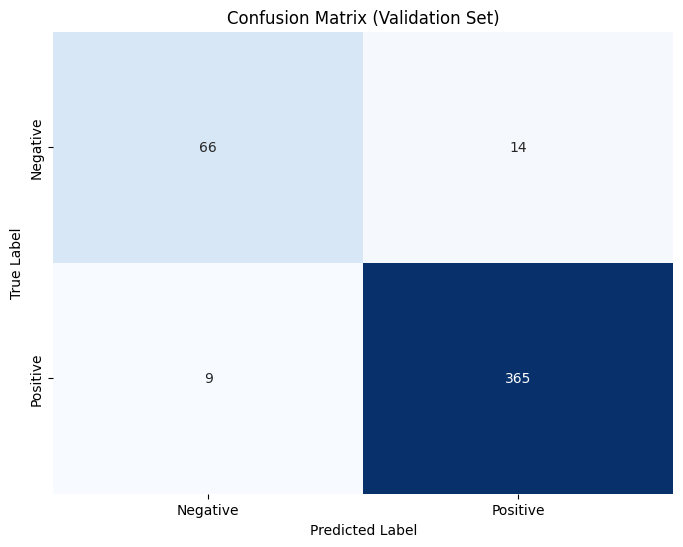

In [57]:
# Usage
train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
model_dir = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Dis')
best_model, val_df_with_predictions, model_path = train_dis(train_file, val_file, model_dir)

Let's look at performance metrics:

- **Accuracy:** 0.9493. The model correctly predicts the sentiment of approximately 94.93% of the validation samples. However, since the data is imbalanced, it doesn't really capture the performance class wise hence looking at other metrics like f1 score.

- **Precision:** 0.9484. The weighted precision of 94.84% suggests that the model makes accurate positive predictions overall, but this is balanced by the proportion of instances in each class.

- **Recall:** 0.9493. The weighted recall of 94.93% means the model correctly identifies positive cases accurately, balanced by the actual distribution of instances in each class

- **F1 Score:** 0.9695. indicates a good balance between precision and recall for the positive class.

- **F1 Macro:** 0.9105. he macro-averaged F1 score of 0.9105 shows good performance across both classes but reflects that performance on the negative class is bringing down the average.

- **Class-wise Accuracy:** [0.825, 0.9759] The accuracy for the negative class is 82.5%, indicating the model is less accurate in predicting negative sentiments.
The accuracy for the positive class is 97.59%, indicating the model is highly accurate in predicting positive sentiments.
This discrepancy suggests an imbalance in the model's performance, where it performs significantly better on positive samples than negative ones.

In [58]:
val_dis_predictions = val_df_with_predictions.copy() # copying for analysis later

## Testing Method Discriminative Code

Testing function

In [59]:
def test_dis(test_file, model_file, output_dir):
    """
    Function to test the discriminative model on the test dataset and save predictions.

    Parameters:
    - test_file: Path to the test file.
    - model_file: Path to the saved model file.
    - output_dir: Directory to save the predictions.

    Returns:
    - test_df: DataFrame with predictions.
    """
    print('Testing started...\n')

    # Load the tokenizer and model
    model_name = 'juliensimon/reviews-sentiment-analysis'
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load the test data
    test_df = read_data(test_file)

    # Prepare the test dataset
    test_dataset, test_df = prepare_dataset(test_df, tokenizer, testing_mode=True)

    # Load the trained model
    print('loading saved model...')
    model = CustomDistilBertForSequenceClassification.from_pretrained(model_name, ignore_mismatched_sizes=True)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    test_predictions = []
    test_confidences = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            test_predictions.extend(preds)
            test_confidences.extend(probs.max(dim=1)[0].cpu().numpy())

    # Convert numerical labels back to sentiment strings
    sentiment_map = {1: 'positive', 0: 'negative'}
    test_sentiments = [sentiment_map[pred] for pred in test_predictions]

    # Add predictions and confidence scores to the test DataFrame
    test_df['out_label_model_dis'] = test_sentiments
    test_df_with_predictions = test_df.copy()
    if 'clean_text' in test_df.columns:
      test_df = test_df.drop('clean_text', axis=1)
    test_df_with_predictions['confidence'] = test_confidences

    # Save the test DataFrame with predictions
    output_path = os.path.join(output_dir, 'test.csv')
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    test_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

    print("\nTesting completed. Predictions saved.")

    # Since there are no true labels, we can only print distribution of predictions
    print("\nDistribution of predicted labels:")
    unique, counts = np.unique(test_predictions, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Label {'positive' if label==1 else 'negative'}: {count} samples")

    return test_df_with_predictions




Testing on test_file

In [60]:
# Usage

model_file = model_path # os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Dis', 'final_model.bin')
output_dir = os.path.join(GOOGLE_DRIVE_PATH, 'data', str(45))

test_df_with_predictions = test_dis(test_file, model_file, output_dir)

Testing started...

Reading file: test.csv
Number of entries found: 409

Top 5 rows:
                                                text out_label_model_unsup  \
0  very firm, durable and holds my phone securely...              positive   
1  Really reduces the glare of headlights in nigh...              positive   
2  Waterspots on my cars chrome trim were irritat...              positive   
3                      awesome sound would buy again              positive   
4  Excellent rear view mirror. Bought for a small...              positive   

   out_label_model_dis  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
loading saved model...
Predictions saved to gdrive/MyDrive/./CE807-24-SU/Assignment/data/45/test.csv

Testing completed. Predictions saved.

Distribution of predicted labels:
Label negative: 75 samples
Label positive: 334 samples


In [61]:
read_data(test_file) # reading file to verify

Reading file: test.csv
Number of entries found: 409

Top 5 rows:
                                                text out_label_model_unsup  \
0  very firm, durable and holds my phone securely...              positive   
1  Really reduces the glare of headlights in nigh...              positive   
2  Waterspots on my cars chrome trim were irritat...              positive   
3                      awesome sound would buy again              positive   
4  Excellent rear view mirror. Bought for a small...              positive   

  out_label_model_dis  
0            positive  
1            positive  
2            positive  
3            positive  
4            positive  


,text,out_label_model_unsup,out_label_model_dis
0,"very firm, durable and holds my phone securely...",positive,positive
1,Really reduces the glare of headlights in nigh...,positive,positive
2,Waterspots on my cars chrome trim were irritat...,positive,positive
3,awesome sound would buy again,positive,positive
4,Excellent rear view mirror. Bought for a small...,positive,positive
...,...,...,...
404,Great addition,positive,positive
405,"thought it would help with the cold and noise,...",positive,positive
406,2nd or 3rd set - Great pads...,positive,positive
407,Took less than 10 minutes. Replaced on a 17 So...,positive,positive


## Analysis (Discriminative Method)

In [62]:
val_df_with_predictions['predicted_sentiment'] = val_df_with_predictions['predicted_label'].apply(lambda x: 'positive' if x == 1 else 'negative')
display(val_df_with_predictions.head(10))

,sentiment,text,clean_text,label,predicted_label,confidence,predicted_sentiment
0,positive,Love the product easy to use,love the product easy to use,1,1,0.996934,positive
1,positive,"Is confortable , Is light weight I really lik...","is confortable , is light weight i really like...",1,1,0.984144,positive
2,positive,pros-<br />brighter than halogen<br />relative...,pros brighter than halogen relatively easy to ...,1,1,0.887000,positive
3,positive,We visited the SCC website to verify the corre...,we visited the scc website to verify the corre...,1,1,0.982498,positive
4,positive,Awesome Awesome Awesome!!!!,awesome awesome awesome!!!!,1,1,0.997236,positive
5,positive,Works however the included caps only fit one o...,works however the included caps only fit one o...,1,0,0.645867,negative
6,positive,Looks great! Thank you!,looks great! thank you!,1,1,0.996458,positive
7,positive,Good value !,good value !,1,1,0.996850,positive
8,negative,I had no idea how to install these - came in p...,i had no idea how to install these came in par...,0,0,0.996642,negative
9,positive,These have worked great for the last 4 month. ...,these have worked great for the last 4 month. ...,1,1,0.996581,positive


The model seems to be highly confident in its predictions for both the classes except for missclassifications like in 5th row, the model isn't really confident in its prediction.

Looking at some more examples from each class

In [63]:
val_dis_predictions = val_df_with_predictions.copy()
pd.set_option('display.max_colwidth', None)
print('Positive Examples:')
display(val_dis_predictions[val_dis_predictions['predicted_sentiment'] == 'positive'].sample(5))

print('\nNegative Examples:')
display(val_dis_predictions[val_dis_predictions['predicted_sentiment'] == 'negative'].sample(5))
pd.reset_option('display.max_colwidth')

Positive Examples:


,sentiment,text,clean_text,label,predicted_label,confidence,predicted_sentiment
385,positive,"Bought this rear sprocket for my 07 Honda XR650L, you can’t go wrong with Renthal products. Went three teeth over the stock 45 and love the new ratio. Rides more like a dirtbike now. Don’t buy the cheap ones-go with quality","bought this rear sprocket for my 07 honda xr650l, you cannot go wrong with renthal products. went three teeth over the stock 45 and love the new ratio. rides more like a dirtbike now. do not buy the cheap onesgo with quality",1,1,0.996706,positive
182,positive,good primer,good primer,1,1,0.984713,positive
432,positive,Seals tight. I use an electric pump so I haven’t used the spout.,seals tight. i use an electric pump so i have not used the spout.,1,1,0.987562,positive
233,positive,Great light.quit bright.wife loves it,great light.quit bright.wife loves it,1,1,0.816612,positive
126,positive,Liked the keyed alike option so I can have only 1 key for several trailers. Locks all worked as designed and I was happy with them.,liked the keyed alike option so i can have only 1 key for several trailers. locks all worked as designed and i was happy with them.,1,1,0.993623,positive



Negative Examples:


,sentiment,text,clean_text,label,predicted_label,confidence,predicted_sentiment
344,negative,"This is done with some kind of dot coloring. I bought the wylee coyote from another company and he is colored solid and perfect so this company is putting out inferior printing and when contacted they said mail it back for a refund. So I have to spend almost fifty cent's to get my two bucks back. Not happy with quality at all. They said they are meant to be seen from a distance on a car bumper so it shouldn't matter, but I don't drive and wanted these for my home.","this is done with some kind of dot coloring. i bought the wylee coyote from another company and he is colored solid and perfect so this company is putting out inferior printing and when contacted they said mail it back for a refund. so i have to spend almost fifty cents to get my two bucks back. not happy with quality at all. they said they are meant to be seen from a distance on a car bumper so it should not matter, but i do not drive and wanted these for my home.",0,0,0.911093,negative
192,negative,"I was underwhelmed with this. Basically, it was spray paint for carpet. It dried hard just like any paint... not soft on carpet like others said. The color was not exactly a good match for my carpet. I guess it will do, but it’s not what I hoped. I would probably return it if I could, but it’s not a returnable product.","i was underwhelmed with this. basically, it was spray paint for carpet. it dried hard just like any paint... not soft on carpet like others said. the color was not exactly a good match for my carpet. i guess it will do, but its not what i hoped. i would probably return it if i could, but its not a returnable product.",0,0,0.989161,negative
245,negative,"Tire lasted a whole 800 miles. And during those 800 miles I accumulated in the neighborhood of 10 holes. Wore through the tread in a matter of 500 miles and hit the belt a couple hundred miles later. Soft thin rubber that should absolutely NOT be on a scooter that can do 55 mph on the road. This is a toy tire, period.","tire lasted a whole 800 miles. and during those 800 miles i accumulated in the neighborhood of 10 holes. wore through the tread in a matter of 500 miles and hit the belt a couple hundred miles later. soft thin rubber that should absolutely not be on a scooter that can do 55 mph on the road. this is a toy tire, period.",0,0,0.690565,negative
97,negative,Used this hub to replace bad hub and problem still exists. Took to mechanic shop and they say the hub is bad. Just purchased in March replaced it in May and now the return window is closed so can't exchange it for a new one.,used this hub to replace bad hub and problem still exists. took to mechanic shop and they say the hub is bad. just purchased in march replaced it in may and now the return window is closed so cannot exchange it for a new one.,0,0,0.852404,negative
223,negative,It could have been a fine product if not for the shedding of the red finer. It is shedding a lot and after dusting I have to clean the fiber which is everywhere in the car. Disappointed.,it could have been a fine product if not for the shedding of the red finer. it is shedding a lot and after dusting i have to clean the fiber which is everywhere in the car. disappointed.,0,0,0.995539,negative


According to these examples, the model showcases following strength and weakness:

**strength:**
- High Confidence in Predictions
- Effective Handling of Clear Sentiments
- Correctly classifies the missclassified examples too.
- Effectively distinguishing between positive and negative sentiments in most
cases

**Weakness:**
- There are cases where the model is highly confident but incorrect in its prediction.
- The model sometimes fails to grasp the nuanced context of a review, especially in cases with mixed sentiments
- Over-reliance on Keywords

**Summary:**
- High Confidence: Model predicts with high confidence in many cases.
- Correct prediction for the missclassified data.
- Good Accuracy: Achieves high accuracy, precision, and recall scores.
- Effective with Clear Sentiments: Performs well with clear and unambiguous reviews.
- High F1 Score: Maintains a balanced precision and recall.
- Complex Review Handling: Issues with long and mixed sentiment reviews.
- Keyword Over-reliance: Heavily relies on certain keywords for predictions.
- less accurate in predicting negative sentiments
- highly accurate in predicting positive sentiments.

## Discriminative Method  End


# Combined Model



The rule based combined model integrates predictions from both unsupervised and discriminative approaches, leveraging their respective strengths to potentially enhance overall prediction accuracy and reliability. The approach employed combines predictions from both models based on their respective confidences and specified weights for each model.

Approach:
The decision rule for choosing which model's prediction to take is based on a weighted comparison of confidence scores:


*   The model compares the product of the normalized weight and confidence score for each model.
*   It selects the prediction from the model with the higher weighted confidence score. This means that even if one model has a slightly higher raw confidence score, the model with a higher weighted confidence might be favored, depending on the relative weights assigned.

Justification: By combining models, this approach leverages the strengths of both supervised and unsupervised methods. For example, the unsupervised model might excel in capturing underlying data patterns not apparent during training, while the supervised model provides precision due to its training on labeled data.

In [64]:
import numpy as np

def combined_prediction(test_df, unsupervised_predictions, supervised_predictions,
                        unsupervised_confidences, supervised_confidences, weights=[0.5, 0.5]):
    """
    Combines predictions from unsupervised and supervised models using a hybrid method
    that considers both confidence scores and weights.

    Args:
        test_df: DataFrame containing the test data.
        unsupervised_predictions: Predictions from the unsupervised model.
        supervised_predictions: Predictions from the supervised model.
        unsupervised_confidences: Confidence scores for unsupervised predictions.
        supervised_confidences: Confidence scores for supervised predictions.
        weights: List of weights for unsupervised and supervised predictions, respectively.

    Returns:
        DataFrame: Test DataFrame with combined predictions and confidence.
        dict: Combined model performance metrics.
    """
    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]

    # Combine predictions and confidences using both weights and confidence scores
    combined_predictions = np.where(
        (normalized_weights[0] * unsupervised_confidences) >= (normalized_weights[1] * supervised_confidences),
        unsupervised_predictions,
        supervised_predictions
    )

    combined_confidences = np.where(
        (normalized_weights[0] * unsupervised_confidences) >= (normalized_weights[1] * supervised_confidences),
        unsupervised_confidences,
        supervised_confidences
    )

    # Converting numerical labels back to sentiment strings
    sentiment_map = {1: 'positive', 0: 'negative'}
    combined_sentiments = [sentiment_map[pred] for pred in combined_predictions]

    # combined predictions and confidence to the test DataFrame
    test_df['combined_prediction'] = combined_sentiments
    test_df['combined_confidence'] = combined_confidences

    true_labels = test_df['sentiment'].map({'positive': 1, 'negative': 0}).values
    combined_metrics = evaluate_metrics(true_labels, combined_predictions)

    print(f"Combined Model Accuracy: {combined_metrics['accuracy']:.4f}")
    print(f"Combined Model F1 Score (Macro): {combined_metrics['f1_macro']:.4f}")
    print(f"Combined Model Precision (Weighted): {combined_metrics['precision']:.4f}")
    print(f"Combined Model Recall (Weighted): {combined_metrics['recall']:.4f}")

    # plotting confusion metrics
    cm = confusion_matrix(true_labels, combined_predictions)

    labels=['negative', 'positive']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return test_df, combined_metrics


Calling the rule based combined model

Combined Model Accuracy: 0.9449
Combined Model F1 Score (Macro): 0.9037
Combined Model Precision (Weighted): 0.9442
Combined Model Recall (Weighted): 0.9449


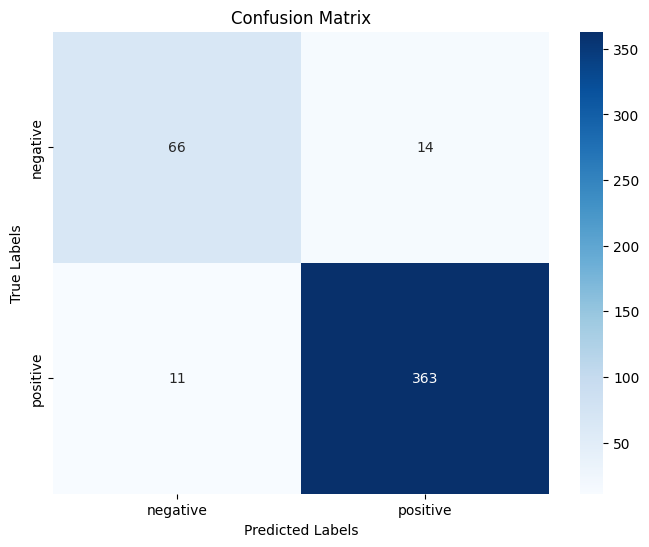

,sentiment,text,combined_prediction,combined_confidence
0,positive,Love the product easy to use,positive,0.996934
1,positive,"Is confortable , Is light weight I really lik...",positive,0.984144
2,positive,pros-<br />brighter than halogen<br />relative...,positive,0.887000
3,positive,We visited the SCC website to verify the corre...,positive,0.982498
4,positive,Awesome Awesome Awesome!!!!,positive,0.997236


In [65]:

val_df_combined, combined_metrics = combined_prediction(
    val_df,
    np.array(val_unsup_predictions['predicted_label']),
    np.array(val_dis_predictions['predicted_label']),
    np.array(val_unsup_predictions['confidence']),
    np.array(val_dis_predictions['confidence']),
    weights=[0.4, 0.6]  # Adjust weights as needed, using higher for discriminative as it showed higher performance
)

display(val_df_combined.head())


We know that the f1 score for unsupervised was around 0.71 and 0.9105 for the other. But the f1 score for combined has gone down instead of going up (which we were hoping).

The performance metrics suggest that the current weights allow the discriminative model to maintain high performance, but the influence of the unsupervised model slightly detracts from the overall performance. Hence trying to give a lower weight to discriminative model.

Combined Model Accuracy: 0.9493
Combined Model F1 Score (Macro): 0.9105
Combined Model Precision (Weighted): 0.9484
Combined Model Recall (Weighted): 0.9493


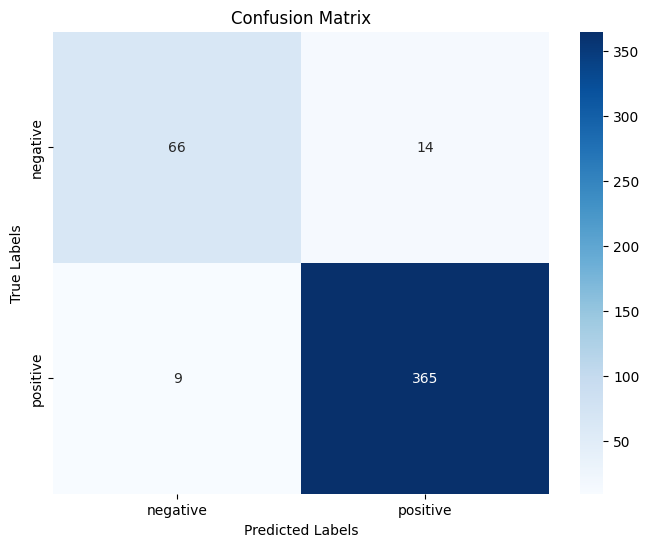

,sentiment,text,combined_prediction,combined_confidence
0,positive,Love the product easy to use,positive,0.996934
1,positive,"Is confortable , Is light weight I really lik...",positive,0.984144
2,positive,pros-<br />brighter than halogen<br />relative...,positive,0.887000
3,positive,We visited the SCC website to verify the corre...,positive,0.982498
4,positive,Awesome Awesome Awesome!!!!,positive,0.997236


In [66]:
val_df_combined, combined_metrics = combined_prediction(
    val_df,
    np.array(val_unsup_predictions['predicted_label']),
    np.array(val_dis_predictions['predicted_label']),
    np.array(val_unsup_predictions['confidence']),
    np.array(val_dis_predictions['confidence']),
    weights=[0.35, 0.65]
)

display(val_df_combined.head())

After lowering the weight a little for unsupervised, exactly same performance as that of discriminative model is seen which implies that:

*   The discriminative model alone is sufficiently powerful, and the unsupervised model’s contribution becomes negligible.
*   The unsupervised model does not capture additional meaningful patterns or insights that the discriminative model misses.
*   The combined model essentially mirrors the performance of the discriminative model, indicating that the discriminative model's predictions are dominant.

## Combined Model End

#State-Of-The-Art Model

The Discriminative model that we used (Fine-tuned DistilBERT) is already a SoTA model. However LLMs like GPT are the top SoTA models as of this year for most of the NLP task including sentiment analysis.

In this section GPT-3.5-Turbo model would be used via API for sentiment classification. Higher vefrsion of GPT is also available but it is almost 10 times more expensive.

Initiallizing OpenAI claient with the api_key

In [67]:
api_key = 'sk-proj-bpYQM75RmbAzVXqq0vLlT3BlbkFJlkg3i2h299MO0EQZbT1e'
client = OpenAI(
    # This is the default and can be omitted
    api_key=api_key,
)

Function to classify sentiment using GPT-3.5-Turbo which takes in a text and creates a prompt to classify the sentiment and how confident the model is in its prediction.

In [68]:
# Reference: https://www.youtube.com/watch?v=s33KHjHIxWk
def sentiment_analysis_gpt(text):
  """
  Classifies the sentiment of the given text using GPT-3.5-Turbo.

  Args:
    text: The text to classify.

  Returns:
    A dictionary containing the predicted sentiment and confidence score.
  """
  prompt = ('Classify the sentiment of this review: "{}"'.format(text) +
            'Sentiment is binary, either "positive" or "negative".' +
            'Return only the sentiment and the confidence score in prediction comma separated.')

  chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "user",
              "content": prompt,
          }
      ],
      model="gpt-3.5-turbo",
  )

  response_ = chat_completion.choices[0].message.content

  return response_.lower()


Example text from validation set

In [69]:
text  = 'The black trim around the outer edge is breaking down and leaving black marks on the upholstery!'

Calling the sentiment_analysis_gpt function and storing the result

In [70]:
result_gpt = sentiment_analysis_gpt(text)

Result visualization

In [71]:
prediction, confidence = result_gpt.split(',')
print(f'prediction: {prediction}, confidence: {confidence}')

prediction: negative, confidence:  0.96


The prediction seems correct accord to text and the model is pretty confident too.

##State-Of-The-Art Model End

# Comparison

## Comparison between Unsupervised and discriminative model

Comparing their performance metrices

In [72]:

def calculate_metrics(df, model_name):
    """
    Calculate performance metrics for a given model.

    Args:
        df (pd.DataFrame): DataFrame containing true labels and predicted labels.
            The DataFrame must have columns 'label' and 'predicted_label'.
        model_name (str): Name of the model for which metrics are calculated.

    Returns:
        pd.Series: A Series containing overall precision, recall, F1 macro score,
                   and class-wise precision and recall for the model.
    """
    metrics = {}
    metrics['Overall Precision'] = precision_score(df['label'], df['predicted_label'], average='weighted')
    metrics['Overall Recall'] = recall_score(df['label'], df['predicted_label'], average='weighted')
    metrics['F1 Macro'] = f1_score(df['label'], df['predicted_label'], average='macro')

    class_precision = precision_score(df['label'], df['predicted_label'], average=None)
    class_recall = recall_score(df['label'], df['predicted_label'], average=None)
    class_labels = ['Negative', 'Positive']  # Adjust according to your labels

    for i, label in enumerate(class_labels):
        metrics[f'Precision ({label})'] = class_precision[i]
        metrics[f'Recall ({label})'] = class_recall[i]


    return pd.Series(metrics, name=model_name)

# Calculate metrics for both models
unsup_metrics = calculate_metrics(val_unsup_predictions, 'Unsupervised')
dis_metrics = calculate_metrics(val_dis_predictions, 'Discriminative')

# Combine metrics into a single DataFrame
metrics_df = pd.concat([unsup_metrics, dis_metrics], axis=1)
display(metrics_df)


,Unsupervised,Discriminative
Overall Precision,0.845969,0.948424
Overall Recall,0.803965,0.949339
F1 Macro,0.715665,0.910534
Precision (Negative),0.462810,0.880000
Recall (Negative),0.700000,0.825000
Precision (Positive),0.927928,0.963061
Recall (Positive),0.826203,0.975936


Interpretation:
- The discriminative model outperforms the unsupervised model across all evaluated metrics.
- It has higher overall precision and recall, indicating more reliable and comprehensive predictions.
- The discriminative model excels particularly in predicting negative sentiment, with a substantial improvement in both precision and recall for the negative class.
- The positive class metrics are high for both models, but the discriminative model still shows superiority.
- These results suggest that the discriminative model is more suitable for the sentiment analysis task in this dataset, offering better performance in identifying both positive and negative sentiments accurately

Comparing their class-wise precision and recall with visualization

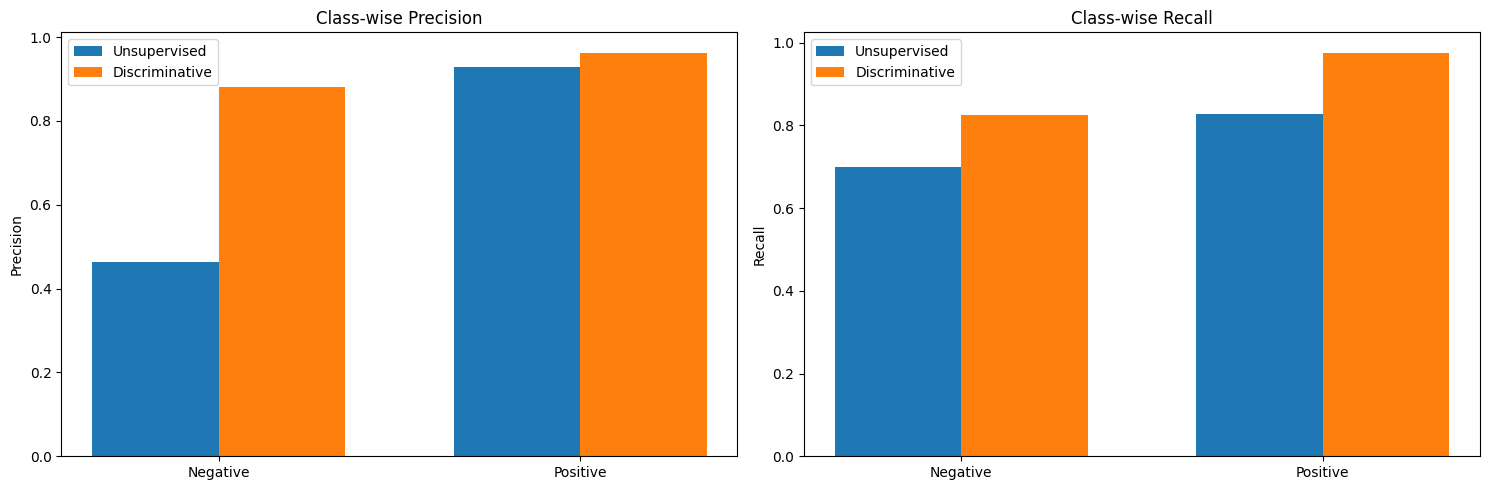

In [73]:
df1 = val_unsup_predictions.copy()
df2 = val_dis_predictions.copy()
model1_name = 'Unsupervised'
model2_name = 'Discriminative'
class_labels = ['Negative', 'Positive']

# Calculate metrics
unsup_class_precision = precision_score(df1['label'], df1['predicted_label'], average=None)
dis_class_precision = precision_score(df2['label'], df2['predicted_label'], average=None)
unsup_class_recall = recall_score(df1['label'], df1['predicted_label'], average=None)
dis_class_recall = recall_score(df2['label'], df2['predicted_label'], average=None)

x = np.arange(len(class_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot class-wise precision
rects1 = ax[0].bar(x - width/2, unsup_class_precision, width, label=model1_name)
rects2 = ax[0].bar(x + width/2, dis_class_precision, width, label=model2_name)
ax[0].set_ylabel('Precision')
ax[0].set_title('Class-wise Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(class_labels)
ax[0].legend()
# Plot class-wise recall
rects1 = ax[1].bar(x - width/2, unsup_class_recall, width, label=model1_name)
rects2 = ax[1].bar(x + width/2, dis_class_recall, width, label=model2_name)
ax[1].set_ylabel('Recall')
ax[1].set_title('Class-wise Recall')
ax[1].set_xticks(x)
ax[1].set_xticklabels(class_labels)
ax[1].legend()

plt.tight_layout()
plt.show()


Interpretation:
- Unlike Unsupervised, discriminative model has a better balance between precision and recall across all classes compared to the unsupervised model.
- The discriminative model is much more accurate in predicting negative sentiment, significantly reducing false positives.
- Unsupervised model is not as at identifying negative instances, indicating more false negatives.
- Both models are quite good at predicting positive sentiment, but negative sentiment predictions could be improved.
- The discriminative model is significantly better at identifying positive instances, indicating fewer false negatives.


Comparing their overall confidence

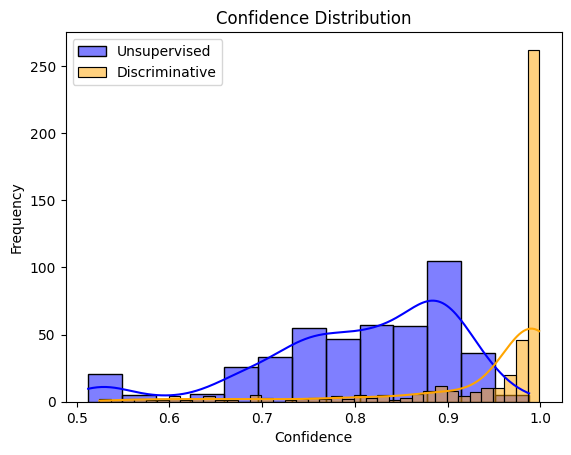

In [74]:
# Confidence distribution plots
sns.histplot(val_unsup_predictions['confidence'], kde=True, label='Unsupervised', color='blue')
sns.histplot(val_dis_predictions['confidence'], kde=True, label='Discriminative', color='orange')
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()
plt.show()

It can be seen that the discriminative model is consistently more confident in its predictions, with a large number of instances having confidence close to 1.0.

The unsupervised model, while also confident, shows more variability in its confidence levels.

Comparing misclassifications

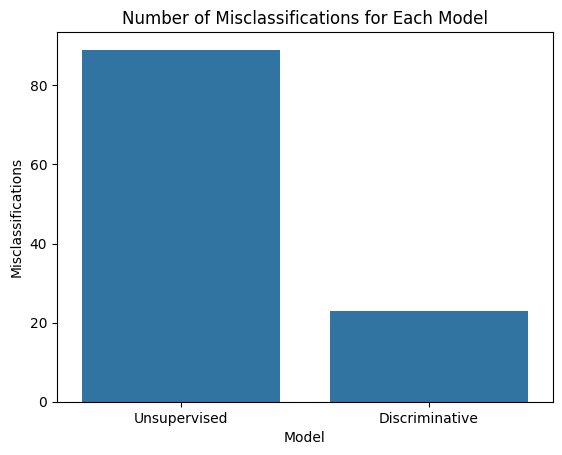


Common misclassifications between unsupervised and discriminative models:


,text,ground_truth,predicted_sentiment_unsup,confidence_unsup,predicted_sentiment_dis,confidence_dis
0,Works however the included caps only fit one of my cans. The diameter was correct but wrong thread contour.,positive,negative,0.678593,negative,0.645867
1,Fits car perfectly.,negative,positive,0.772603,positive,0.996251
2,Very pleased to be able to find replacement knob that matches and fits. Always breaks though I have replaced it several times in that couple of years.,negative,positive,0.806082,positive,0.995449
3,"Changed my mind a bit, it does work on smaller scratches. Not on medium or large ones though, but it works ok.",negative,positive,0.846865,positive,0.758684
4,"I was going a bit nuts with my windshield recently - no matter how many times I cleaned it about a day later I'd discover some area I had missed. Not sure, but I think a deodorizer I had in the car was causing things to appear more prominently. This plus some Windex in a can got it in one shot, except for about half an inch from the spot where the windshield meets the dashboard.<br /><br />Due to the design of the handle you're limited to how small of a corner space you can have dead-on. Now, you can go sideways, but that sort of gets into a complex seat ballet in the car.<br /><br />Overall, does the trick, comes with a little squirter bottle which I have not used yet (I needed Windex level cleaning) but looks like something useful.<br /><br />While I have not cleaned the back windows in my vehicle (kids man,) I'm pretty sure this will reach where I need to go with them.",negative,positive,0.763592,positive,0.911190


In [75]:
# Identifing misclassified examples for unsupervised model
unsup_misclassified = val_unsup_predictions[val_unsup_predictions['label'] != val_unsup_predictions['predicted_label']]

# Identifing misclassified examples for discriminative model
dis_misclassified = val_dis_predictions[val_dis_predictions['label'] != val_dis_predictions['predicted_label']]


# Plot comparison of misclassifications
misclass_counts = {
    'Model': ['Unsupervised', 'Discriminative'],
    'Misclassifications': [len(unsup_misclassified), len(dis_misclassified)]
}

misclass_df = pd.DataFrame(misclass_counts)
sns.barplot(x='Model', y='Misclassifications', data=misclass_df)
plt.title('Number of Misclassifications for Each Model')
plt.show()

# common misclassifications between the two models
common_misclassified = unsup_misclassified.merge(dis_misclassified, on='text', suffixes=('_unsup', '_dis'))
common_misclassified['ground_truth'] = common_misclassified['sentiment_unsup']
print("\nCommon misclassifications between unsupervised and discriminative models:")
pd.set_option('display.max_colwidth', None)
display(common_misclassified[['text',  'ground_truth', 'predicted_sentiment_unsup', 'confidence_unsup', 'predicted_sentiment_dis', 'confidence_dis']].head(5))
pd.reset_option('display.max_colwidth')


Interpretation:
- The discriminative model has fairly less missclassification.
- For serial no. 0 , both models couldn't understand the ambiguity. Howeve,r their confidence is low in prediction which is good.
- Both models were able to correctly classify the miss-classified (like serial no. 1)
- Both models couldn't understand the sarcasm in example with serial no. 2. Also the discriminative model is very overconfident in this case.
- For serial no 4 and 3, despite the mixed sentiment the Ground truth is actually wrong and predictions are correct. Both the models were able to get the context with high confidence which is great.

## Comparing Unsupervised, discriminative and SoTA model

Creating examples for comparison

In [76]:
# Merging the two dataframes
merged_df = val_unsup_predictions.merge(val_dis_predictions, on='text', suffixes=('_unsup', '_dis'))


# Select rows with specified indices
selected_rows = merged_df.iloc[[0, 7, 43, 85, 138, 260, 282]]

example_df = pd.DataFrame()
example_df['Serial No.'] = np.arange(1, len(example_df) + 1)
example_df['Category'] = ['easy','easy','hard','hard','easy','ambiguous','hard']
example_df['Serial No.'] = np.arange(1, len(example_df) + 1)
example_df['text'] = selected_rows['clean_text_unsup'].values
example_df['original_label'] = selected_rows['sentiment_unsup'].values
example_df['prediction_unsup'] = selected_rows['predicted_sentiment_unsup'].values
example_df['confidence_unsup'] = selected_rows['confidence_unsup'].values
example_df['prediction_dis'] = selected_rows['predicted_sentiment_dis'].values
example_df['confidence_dis'] = selected_rows['confidence_dis'].values

# Display the selected rows
display(example_df)


,Serial No.,Category,text,original_label,prediction_unsup,confidence_unsup,prediction_dis,confidence_dis
0,1,easy,love the product easy to use,positive,positive,0.773061,positive,0.996934
1,2,easy,good value !,positive,positive,0.630032,positive,0.996850
2,3,hard,the dilution ratio on this allows you to make ...,negative,negative,0.829751,positive,0.636293
3,4,hard,i purchased this for my semi worn armrest to p...,positive,positive,0.781125,negative,0.608185
4,5,easy,i bought these to replace my worn out headligh...,positive,negative,0.895176,positive,0.992711
5,6,ambiguous,customer service and shipping was first rate a...,negative,negative,0.890453,positive,0.886653
6,7,hard,this gel is not sticky even when warmed up! i ...,negative,positive,0.811304,negative,0.992177


Fetching results from SoTA model API

In [77]:
print('Fetching classifications from SoTA GPT model via API..')
predictions_gpt = []
confidences_gpt = []

for text in example_df['text']:
    try:
        result_gpt = sentiment_analysis_gpt(text)
        prediction, confidence = result_gpt.split(',')
        predictions_gpt.append(prediction.strip())
        confidences_gpt.append(float(confidence.strip()))
    except ValueError:
        print(f"Skipping problematic response: {result_gpt}")
        predictions_gpt.append(None)
        confidences_gpt.append(None)
    # Adding a delay to avoid hitting rate limits
    time.sleep(0.5)

example_df['prediction_GPT'] = predictions_gpt
example_df['confidence_GPT'] = confidences_gpt

print('results fetched..')


Fetching classifications from SoTA GPT model via API..
results fetched..


Visualizing all models results

In [78]:
pd.set_option('display.max_colwidth', None)
display(example_df)
pd.reset_option('display.max_colwidth')

,Serial No.,Category,text,original_label,prediction_unsup,confidence_unsup,prediction_dis,confidence_dis,prediction_GPT,confidence_GPT
0,1,easy,love the product easy to use,positive,positive,0.773061,positive,0.996934,positive,0.95
1,2,easy,good value !,positive,positive,0.630032,positive,0.996850,positive,0.96
2,3,hard,"the dilution ratio on this allows you to make maybe 23 gallons total which really is not that much when you are spraying it all over the wheels. you need to scrub to actually get the brake dust off spraying it on and rinsing off is not going to clean neglected wheels enough. id rather just use wheel acid and iron remover its far more economical. even ps break buster in a foamer is going to do the exact same thing as this, and you can buy it way cheaper. its not a bad product its just too expensive for what it is.",negative,negative,0.829751,positive,0.636293,negative,0.92
3,4,hard,"i purchased this for my semi worn armrest to prevent further damage. first of all, it does not cover the entire armrest. this might have been done intentionally so that you can push the button to open the storage container, but it makes the armrest area look silly. due to the style of my armrest, i had to give the installation of this one star. i have a lexus es350. this armrest has two elastic bands to help keep it attached to the top of the armrest. the way my armrest is designed, it opens by sliding the top back, this method of the elastic bands does not work for my top. therefore, i have no way of installing this without ruining the leather on the top of my existing armrest. when i want to use this i have to put it on and off. it is very comfortable, and the color is spot on for matching my beige interior.",positive,positive,0.781125,negative,0.608185,negative,0.84
4,5,easy,i bought these to replace my worn out headlights and i must say it definitely changes the look and it was worth the money the only thing i can say is the caps behind the headlight bulbs are a little difficult to remove and install i put a drop of motor oil on the gasket and they screwed in like butter would definitely buy again.,positive,negative,0.895176,positive,0.992711,positive,0.95
5,6,ambiguous,customer service and shipping was first rate and deserves 5 stars. these mats did not hang properly on my truck seats so i replaced them.,negative,negative,0.890453,positive,0.886653,negative,0.85
6,7,hard,"this gel is not sticky even when warmed up! i broke it up in to smaller pieces to clean up cup holders, console, shifters, etc and the gel only picks up random bits of dust and hair. what a waste of money. i purchased 2. read the reviews they are accurate. go to dollar stores and purchase the childrens sticky wall climbers the kind you throw at the wall and the creatures roll down the wall. nice and sticky and picks up dog hair, food crumbs as well as dust. the one star is for the nice packaging.......",negative,positive,0.811304,negative,0.992177,negative,0.95


**Interpretation:**

The table shows which models got the classification correct bast on the sentiment_should_be column


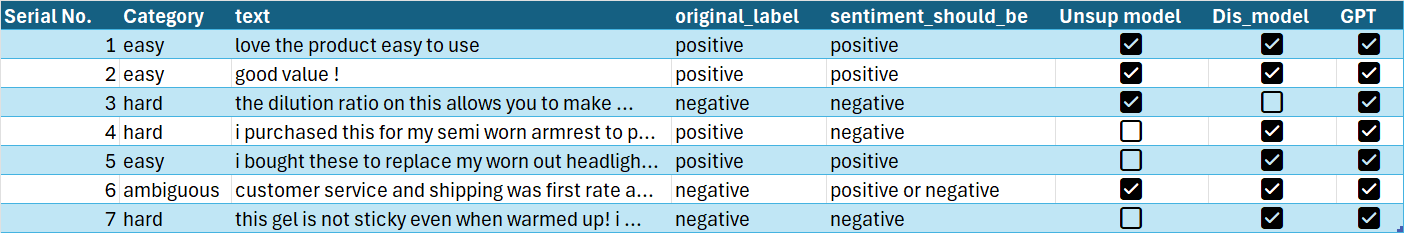

- Serial No. 1 (Easy): All models predicted correctly with high confidence.
- Serial No. 2 (Easy): All models predicted correctly with the discriminative model having the highest confidence. However, the unsupervised one wasn't so sure. It is soom to be not so good with text with few words.
- Serial No. 3 (Hard): Discriminative model incorrectly predicted positive. It could not pick out the overall context. unsupervised and GPT predicted correctly though that too with high confidence. discriminative model was less sure about this one though.
- Serial No. 4 (Hard): This one was actually misclassified. Despite that discriminative and GPT predicted correctly. However, unsupervised model was not able to figure it out.
- Serial No. 5 (Easy): Unsupervised model incorrectly predicted negative that too with high confidence which isn't good; discriminative and GPT predicted correctly. The unsupervised model didn't capture the sarcasm, however the other too models did.
- Serial No. 6 (Ambiguous): For this actually both labels could be correct depending on opinion, so all got this one checked.
- Serial No. 7 (Hard): Unsupervised model incorrectly predicted positive, it could not figure out the entire context and was also overconfident; discriminative and GPT predicted correctly with high confidence.


#### Final Take:
In terms of dataset and training:
- Unsupervised Models: Performance may vary based on the quality and nature of the data used for training. Simpler methods might miss nuanced context.
- Discriminative Models: Performance generally improves with more labeled training data, allowing the model to learn from diverse examples.
- GPT Models: Extensive pre-training on large datasets enhances their ability to understand and generate text, making them highly effective in sentiment analysis.

In terms of confidence Scores:
- Discriminative and GPT Models: Higher confidence scores in correct predictions indicate the model's robustness in understanding context and sentiment.
- Unsupervised Models: Lower confidence or incorrect predictions in complex cases reflect limitations in capturing nuanced sentiment.